# Beta learning

## Get packages and JPMaQS data

The notebook is structured to illustrate the concepts discussed in the post ["How “beta learning” improves macro trading strategies"](https://macrosynergy.com/research/how-beta-learning-improves-macro-trading-strategies/) on the Macrosynergy website. The main objective is to demonstrate how macro beta estimation and "beta learning" can enhance the robustness of macro trading strategies, particularly through the example of an emerging market FX carry strategy.

The notebook is organized into the following main sections:

- __Get Packages and JPMaQS Data:__ This section is dedicated to installing and importing the necessary Python packages for the analysis. It includes standard Python libraries like pandas and seaborn, as well as the [`scikit-learn`](https://scikit-learn.org/stable/) package and the specialized [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package. The notebook relies heavily on the [`macrosynergy learning`](https://github.com/macrosynergy/macrosynergy/tree/develop/macrosynergy/learning) sub-package. Additionally, this part of the notebook does preliminary data exploration - it looks at missing categories in the dataset, starting years of time series, and blacklists periods of official exchange rate targets, illiquidity, or convertibility-related distortions in FX markets, which can significantly impact the behavior of currency markets. 

- __Estimating and evaluating beta:__ In this part, the notebook applies a statistical learning process that considers selected statistical models and hyperparameters and sequentially picks the optimal model to estimate betas for positions in the following months. The process follows three main steps:
    - _setting the rules of a sequential learning process_ regarding the models and hyperparameters considered, the cross-validation splitters, and the criterion for model selections.
    - _apply learning to expanding samples of panels of target and benchmark returns_. This means we review the model choice periodically and estimate the beta for a subsequent out-of-sample period prior to the next re-estimation date. 
    - _adjust target returns_ for the influence of the hedging basket based on the learned betas.

In particular, the three learning approaches in the notebook are:

- __Learning with single-frequency OLS and LAD regressions__,
- __Learning with dual-frequency optimal regression combinations__ (averaging daily and weekly regression estimates) and
- __Learning with separate correlation and volatility estimators__ (estimating the correlation and volatility of the betas separately, allowing for different lookback periods of these two estimated parameters)  

Lastly, we create a hedged real carry strategy and demonstrate its outperformance of the unhedged equivalent:

- __Beta application: hedged real carry strategy:__ this part calculates the performance of emerging markets FX forward returns and carries before and after hedging using estimated betas and, most crucially, evaluates various signals, using principals outlined in the post ["Evaluating macro trading signals in three simple steps"](https://macrosynergy.com/research/evaluating-macro-trading-signals-in-three-simple-steps/). This analysis is implemented in three steps: 
    - _Panel correlation_: Analyze the relationship between macro signals and subsequent returns.
    - _Accuracy and correlation robustness_: Assess the robustness of macro signals predictions.
    - _Naive PnL analysis_: Calculate naive profit and loss series by taking positions according to normalized signals, rebalancing monthly. 

This notebook primarily relies on the standard packages available in the Python data science stack. However, the `macrosynergy` package is additionally required for two purposes:

- Downloading JPMaQS data: The macrosynergy package facilitates the retrieval of JPMaQS data used in the notebook. 

- For analyzing quantamental data and value propositions: The macrosynergy package provides functionality for performing quick analyses of quantamental data and exploring value propositions. The new subpackage [macrosynergy.learning](https://docs.macrosynergy.com/macrosynergy/learning/index.html) integrates the `macrosynergy` package and associated JPMaQS data with the widely-used `scikit-learn` library and is used extensively in this notebook. 

For detailed information and a comprehensive understanding of the macrosynergy package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn
import macrosynergy.learning as msl
import macrosynergy.visuals as msv

from macrosynergy.download import JPMaQSDownload

from sklearn.ensemble import VotingRegressor

import scipy.stats as stats

from timeit import default_timer as timer
from datetime import timedelta, date, datetime

import warnings

warnings.simplefilter("ignore")

For convenience, we organize the required cross-sections into specific lists. This notebook specifically utilizes the list `cids_emfx`, which includes emerging market FX currencies, excluding `SGD` due to the lack of data.

In [2]:
# Cross-sections of interest

cids_dm = [
    "AUD",
    "CAD",
    "CHF",
    "EUR",
    "GBP",
    "JPY",
    "NOK",
    "NZD",
    "SEK",
    "USD",
]  # DM currency areas
cids_latm = ["BRL", "COP", "CLP", "MXN", "PEN"]  # Latam countries
cids_emea = ["CZK", "HUF", "ILS", "PLN", "RON", "RUB", "TRY", "ZAR"]  # EMEA countries
cids_emas = [
    "IDR",
    "INR",
    "KRW",
    "MYR",
    "PHP",
    "SGD",
    "THB",
    "TWD",
]  # EM Asia countries
cids_em = cids_latm + cids_emea + cids_emas
cids = sorted(cids_dm + cids_em)

# FX-specific cross sections

cids_nofx = [
    "EUR",
    "USD",
    "SGD",
]  # not small or suitable for this analysis for lack of data
cids_fx = list(set(cids) - set(cids_nofx))
cids_emfx = list(set(cids_em).intersection(cids_fx))

JPMaQS indicators are conveniently grouped into six main categories: Economic Trends, Macroeconomic balance sheets, Financial conditions, Shocks and risk measures, Stylized trading factors, and Generic returns. Each indicator has a separate page with notes, description, availability, statistical measures, and timelines for main currencies. The description of each JPMaQS category is available under the [Macro quantamental academy](https://macrosynergy.com/academy/quantamental-indicators-on-jpmaqs/). For tickers used in this notebook see [FX forward returns](https://macrosynergy.com/academy/notebooks/fx-forward-returns/), [FX forward betas](https://macrosynergy.com/academy/notebooks/fx-forward-betas/), [FX forward carry](https://macrosynergy.com/academy/notebooks/fx-forward-carry/), [FX tradeability and flexibility](https://macrosynergy.com/academy/notebooks/fx-tradeability-and-flexibility/), [Directional risk basket returns](https://macrosynergy.com/academy/notebooks/directional-risk-basket-returns/), and [Equity index future returns](https://macrosynergy.com/academy/notebooks/equity-index-future-returns/)

In [3]:
# Categories of interest

main = ["FXXR_NSA", "FXXRHvGDRB_NSA"] # FX forward return, % of notional: dominant cross / against USD and Return on FX forward, hedged against market direction risk
econ = []
xtra = [
    "FXXRBETAvGDRB_NSA", #  FX forward return beta with respect to a global directional risk basket.
    "FXCRR_NSA",  #  Nominal forward-implied carry vs. dominant cross: % ar
    "FXTARGETED_NSA", # Exchange rate target dummy
    "FXUNTRADABLE_NSA", # FX untradability dummy
]  # related market categories

xcats = main + econ + xtra

xtix = [
    "GLB_DRBXR_NSA", # cross-asset directional risk basket return (GLB)
    "GLB_DRBCRR_NSA", # cross-asset basket carry (GLB)
    "GEQ_DRBXR_NSA", # equity index future basket return (GEQ)
    "GEQ_DRBCRR_NSA", # equity index future basket carry (GEQ)
    "USD_EQXR_NSA", # USD equity index future return
    "USD_EQCRR_NSA", # USD equity index future carry
]

The `JPMaQS` indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying *ticker strings*, formed by appending an indicator category code `<category>` to a currency area code `<cross_section>`. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where `<info>` denotes the time series of information for the given cross-section and category. 

The following types of information are available:

* `value` giving the latest available values for the indicator
* `eop_lag` referring to days elapsed since the end of the observation period
* `mop_lag` referring to the number of days elapsed since the mean observation period
* `grade` denoting a grade of the observation, giving a metric of real time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers, start_date, metrics)` method to obtain the data. Here `tickers` is an array of ticker strings, `start_date` is the first release date to be considered and `metrics` denotes the types of information requested.

In [4]:
# Download series from J.P. Morgan DataQuery by tickers

start_date = "1995-01-01"
tickers = [cid + "_" + xcat for cid in cids for xcat in xcats] + xtix
print(f"Maximum number of tickers is {len(tickers)}")

# Retrieve credentials

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

# Download from DataQuery

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as downloader:
    start = timer()
    assert downloader.check_connection()
    df = downloader.download(
        tickers=tickers,
        start_date=start_date,
        metrics=["value"],
        suppress_warning=True,
        show_progress=True,
    )
    end = timer()

dfx = df.copy()

print("Download time from DQ: " + str(timedelta(seconds=end - start)))

Maximum number of tickers is 192
Timestamp UTC:  2024-12-03 19:02:34
Connection successful!


Requesting data: 100%|█████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.71it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
6 out of 192 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
3 out of 7809 dates are missing.
Download time from DQ: 0:00:15.660326


## Availability and blacklisting

### Availability

It is essential to assess data availability before conducting any analysis. It allows for the identification of any potential gaps or limitations in the dataset, which can impact the validity and reliability of analysis, ensure that a sufficient number of observations for each selected category and cross-section is available, and determine the appropriate periods for analysis. 

The [`missing_in_df()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#detect-missing-categories-or-cross-sections-with-missing-in-df) function in `macrosynergy.management` allows the user to quickly check whether or not all requested categories have been downloaded.

In [5]:
cids_exp = cids_fx  # cids expected in category panels
msm.missing_in_df(dfx, xcats=xcats, cids=cids_exp)

No missing XCATs across DataFrame.
Missing cids for FXCRR_NSA:          []
Missing cids for FXTARGETED_NSA:     []
Missing cids for FXUNTRADABLE_NSA:   []
Missing cids for FXXRBETAvGDRB_NSA:  []
Missing cids for FXXRHvGDRB_NSA:     []
Missing cids for FXXR_NSA:           []


The [`check_availability()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#view-available-data-history-with-check-availability) function in `macrosynergy.management` displays the start dates from which each category is available for each requested country, as well as missing dates or unavailable series.

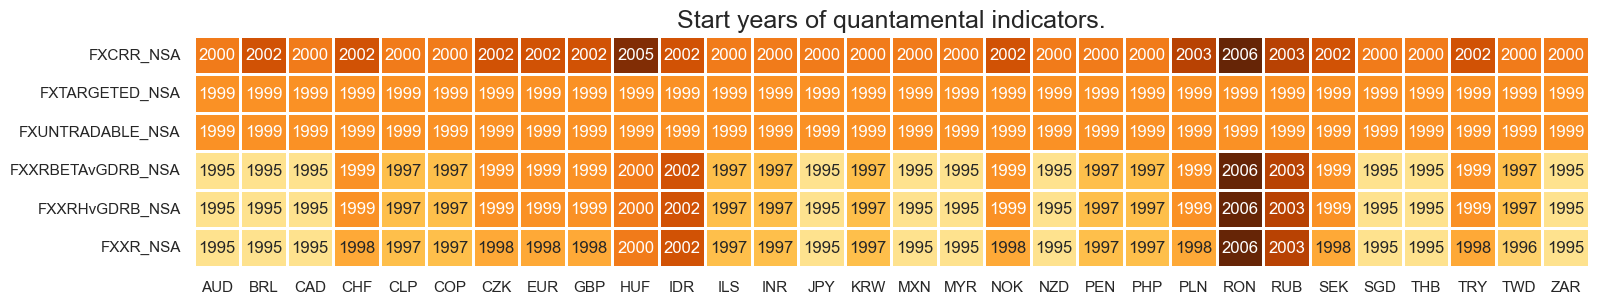

In [6]:
msm.check_availability(df, xcats=xcats, cids=cids, missing_recent=False)

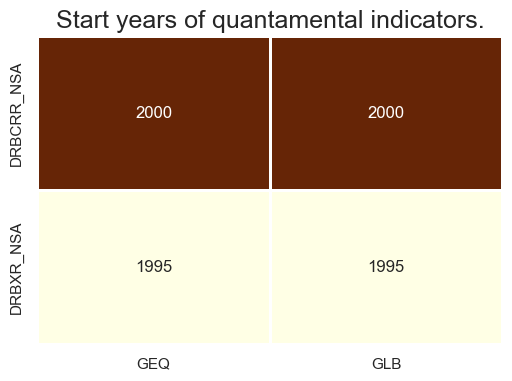

In [7]:
cidx = ["GLB", "GEQ"]
msm.check_availability(
    df,
    xcats=["DRBXR_NSA", "DRBCRR_NSA"],
    cids=cidx,
    missing_recent=False,
    start_size=(6, 4),
)

### Blacklisting

Identifying and isolating periods of official exchange rate targets, illiquidity, or convertibility-related distortions in FX markets is the first step in creating an FX trading strategy. These periods can significantly impact the behavior and dynamics of currency markets, and failing to account for them can lead to inaccurate or misleading findings. The [`make_blacklist()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#exclude-series-sections-with-make-blacklist) helper function creates a standardized dictionary of blacklist periods:

In [8]:
dfb = df[df["xcat"].isin(["FXTARGETED_NSA", "FXUNTRADABLE_NSA"])].loc[
    :, ["cid", "xcat", "real_date", "value"]
]
dfba = (
    dfb.groupby(["cid", "real_date"])
    .aggregate(value=pd.NamedAgg(column="value", aggfunc="max"))
    .reset_index()
)
dfba["xcat"] = "FXBLACK"
fxblack = msp.make_blacklist(dfba, "FXBLACK")
fxblack

{'BRL': (Timestamp('2012-12-03 00:00:00'), Timestamp('2013-09-30 00:00:00')),
 'CHF': (Timestamp('2011-10-03 00:00:00'), Timestamp('2015-01-30 00:00:00')),
 'CZK': (Timestamp('2014-01-01 00:00:00'), Timestamp('2017-07-31 00:00:00')),
 'ILS': (Timestamp('1999-01-01 00:00:00'), Timestamp('2005-12-30 00:00:00')),
 'INR': (Timestamp('1999-01-01 00:00:00'), Timestamp('2004-12-31 00:00:00')),
 'MYR_1': (Timestamp('1999-01-01 00:00:00'), Timestamp('2007-11-30 00:00:00')),
 'MYR_2': (Timestamp('2018-07-02 00:00:00'), Timestamp('2024-12-02 00:00:00')),
 'PEN': (Timestamp('2021-07-01 00:00:00'), Timestamp('2021-07-30 00:00:00')),
 'RON': (Timestamp('1999-01-01 00:00:00'), Timestamp('2005-11-30 00:00:00')),
 'RUB_1': (Timestamp('1999-01-01 00:00:00'), Timestamp('2005-11-30 00:00:00')),
 'RUB_2': (Timestamp('2022-02-01 00:00:00'), Timestamp('2024-12-02 00:00:00')),
 'SGD': (Timestamp('1999-01-01 00:00:00'), Timestamp('2024-12-02 00:00:00')),
 'THB': (Timestamp('2007-01-01 00:00:00'), Timestamp('20

# Estimating beta with statistical learning

In order to fascilitate beta learning, we follow the broad learning process outlined in the post [Signal optimization basics](https://macrosynergy.com/research/optimal-signals/). This entails using cross-validation at each estimation date for both model and hyperparameter selection, storing out-of-sample quantities (generally predictions but in this case, out-of-sample hedged returns) and consuming these samples to form a larger training set. 

## Cross-validation splitters

Below, we've created a basic toy dataset to illustrate the cross-validation splitters that are used in this post.

In [9]:
Xy_long = msm.categories_df(
    df=dfx,
    xcats=["FXCRR_NSA", "FXXR_NSA"],
    cids=cids,
    lag=1,
    xcat_aggs=["mean", "sum"],
    start="1999-01-01",
).dropna()

X = Xy_long.iloc[:, 0].to_frame()
y = Xy_long.iloc[:, 1]

The `ExpandingFrequencyPanelSplit()` class in the `macrosynergy.learning` subpackage is a new cross-validation splitter that we provide, which acts similarly to the existing `ExpandingIncrementPanelSplit()` class. Instead of specifying the number of training intervals and the number of subsequent out-of-sample test samples, an expansion frequency (`expansion_freq`) and the frequency for the subsequent test expansion (`test_freq`) is specified. The initial training set is governed by the `min_cids` and `min_periods` parameters: it is the smallest set such that at least `min_cids` cross-sections comprise `min_periods` training samples, in units of the underlying dataset frequency. In the example toy dataset, this would be monthly. 

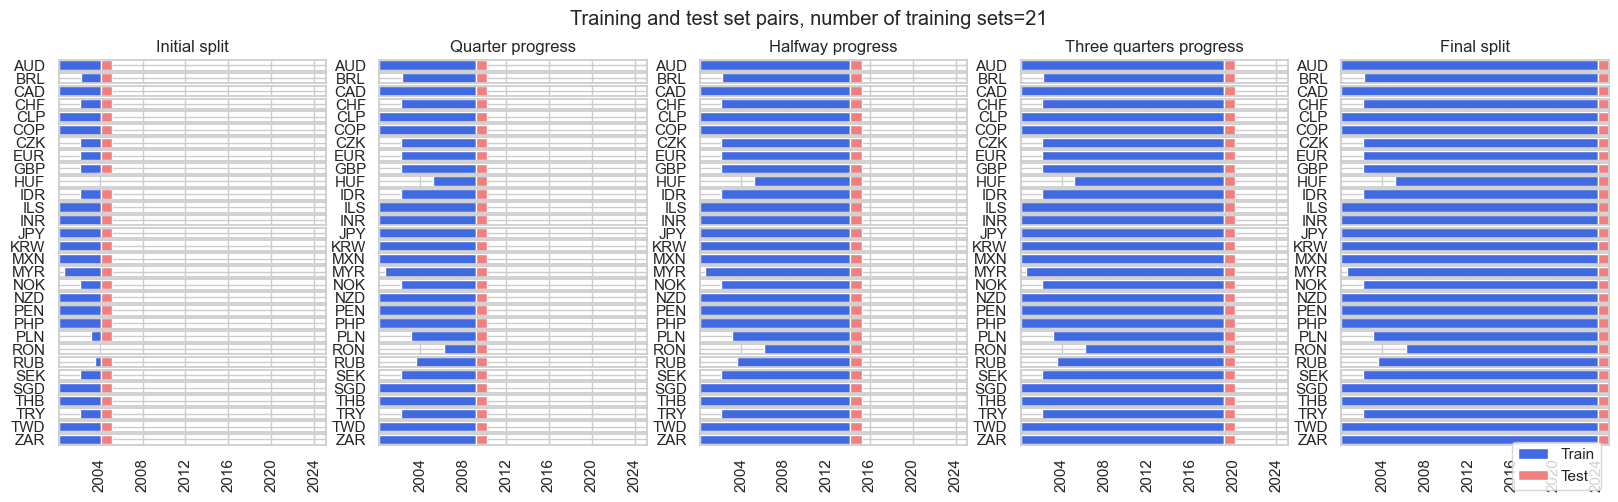

In [10]:
frequency_splitter = msl.ExpandingFrequencyPanelSplit(
    expansion_freq="Y", test_freq="Y", min_cids=1, min_periods=12 * 4
)
frequency_splitter.visualise_splits(X, y)

For hyperparameter and model selection, we use the `ExpandingKFoldPanelSplit()` sequential splitter for cross-validation. The [ExpandingKFoldPanelSplit](https://github.com/macrosynergy/macrosynergy/blob/develop/macrosynergy/learning/panel_time_series_split.py#L332) class allows instantiating panel splitters where a fixed number of splits is implemented, but temporally adjacent panel training sets always precede test sets chronologically and where the time span of the training sets increases with the implied date of the train-test split. It is equivalent to `scikit-learn’s` [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) but adapted for panels.

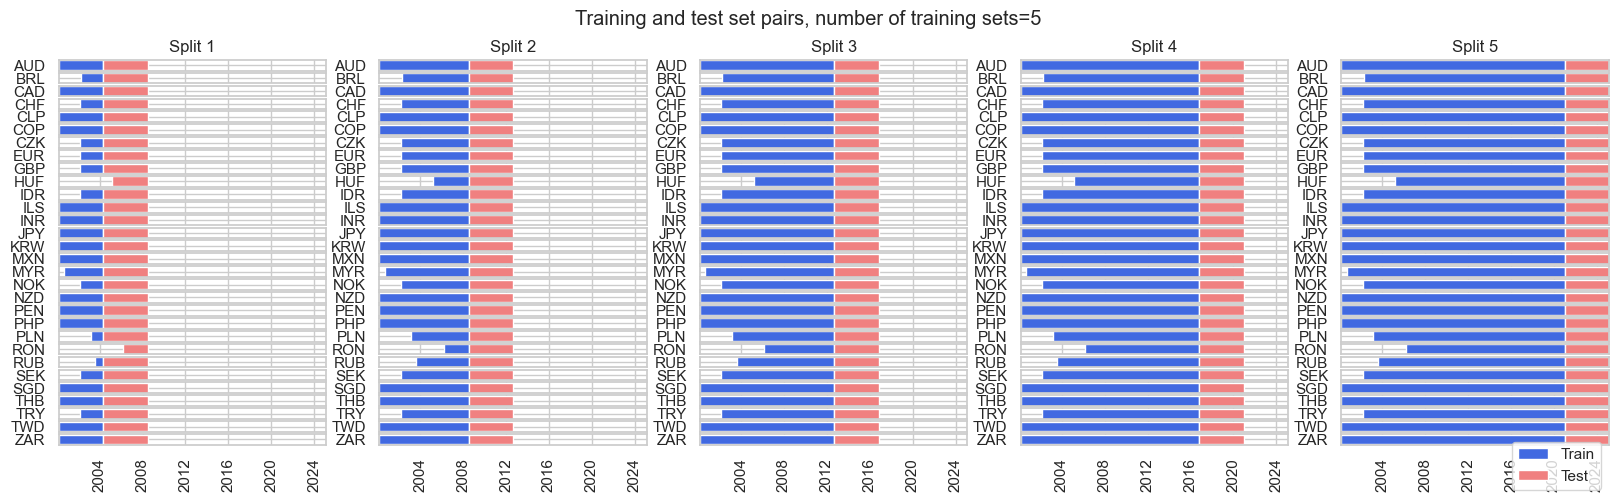

In [11]:
expanding_kfold_splitter = msl.ExpandingKFoldPanelSplit()
expanding_kfold_splitter.visualise_splits(X, y)

## Learning with single-frequency OLS and quantile regressions

The first learning approach is learning with single-frequency OLS and quantile regressions. We principally apply the statistical learning process to the 20-currency panel from 1999 to 2024, subject to tradability and exchange rate flexibility as tracked by quantamental system dummies. The start date of the sample reflects the introduction of the euro and of reliable data on the tradability of many EM FX forward markets. The number of tradable cross-sections broadened in the 2000s, implying an imbalanced panel. The minimum requirement for the learning process has been set at 12 months of data. Betas are being re-estimated every quarter.

We consider two standard regression models for estimating betas: 

- a least squares regression and 
- a least absolute deviation regression (quantile regression for median, LAD). 

The hyperparameters are the frequency of the returns used for estimation (daily or weekly) and the lookback periods, which are either working days (21, 63, 126, 252, 504, or 756), i.e., approximately between one month and three years, or weeks (24, 48, 96, or 144).

In [12]:
# Models and hyperparameters

models = {
    "LR_ROLL": msl.LinearRegressionSystem(
        min_xs_samples=21, fit_intercept=True, positive=False
    ),
    "LAD_ROLL": msl.LADRegressionSystem(
        min_xs_samples=21, fit_intercept=True, positive=False
    ),
}

grid = {
    "LR_ROLL": [
        {"roll": [21, 21 * 3, 21 * 6, 21 * 12, 21 * 24, 21 * 36], "data_freq": ["unadjusted"]},
        {"roll": [4 * 6, 4 * 12, 4 * 24, 4 * 36], "data_freq": ["W"]},
    ],
    "LAD_ROLL": [
        {"roll": [21, 21 * 3, 21 * 6, 21 * 12, 21 * 24, 21 * 36], "data_freq": ["unadjusted"]},
        {"roll": [4 * 6, 4 * 12, 4 * 24, 4 * 36], "data_freq": ["W"]},
    ],
}

The criterion for optimizing models and hyperparameters  `eval_score` is the negative of the mean absolute correlation of returns with the benchmark, i.e., the global directional risk basket return. `msl.neg_mean_abs_corr` is a custom sklearn scorer for beta estimation to return the negative mean absolute correlation between benchmark returns and computed hedged returns over a panel, based on estimated beta for each cross-section, with mean taken over the cross-sections.

In [13]:
# Cross-validation splitter and evaluation score

inner_splitter = {"ExpandingKFold": msl.ExpandingKFoldPanelSplit(n_splits=5)}
eval_score = {"neg_mean_abs_corr": msl.neg_mean_abs_corr}

In [14]:
dfxx = dfx[dfx['real_date'] >= '1999-01-01']

Here we instantiate the class `BetaEstimator`. The class estimates betas with seemingly unrelated linear regression (SUR) sequentially with expanding panel data windows. Statistical learning determines the model and hyperparameter choices sequentially using a given performance metric. Cross-sectional betas and out-of-sample "hedged" returns are stored in quantamental dataframes.

In [15]:
# Class instantiation

cidx = cids_emfx
be = msl.BetaEstimator(
    df=dfxx, xcats="FXXR_NSA", cids=cidx, benchmark_return="GLB_DRBXR_NSA"
)

The `estimate_beta()` function produces betas and hedged returns by learning using the `models` and `grid` dictionaries specified above, the `ExpandingKFoldPanelSplit` as `inner_splitter` and `eval_score` as the scorer.

In [16]:
%%time
# Produce betas and hedged returns by learning

be.estimate_beta(
    beta_xcat="BETAvGDRB_OQR",
    hedged_return_xcat="FXXRHvGDRB_OQR",
    inner_splitters=inner_splitter,
    scorers=eval_score,
    models=models,
    hyperparameters=grid,
    min_cids=1,
    min_periods=21 * 12,
    est_freq="Q", # Change to "M", "W" or "D" if more computational resources are available
    n_jobs_outer=12,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 5min 36s


The "heatmap" displays the actual selected model: a range of different model versions qualified as optimal over time. At the end of the sample of the learning process and often before, the OLS regression model (LR) with the 2-year lookback prevailed. Short lookback models rarely qualified. Both least squares and least absolute distance estimators have been chosen. (Interestingly, if one includes blacklisted periods with untradable markets and return distortions, the preferred method becomes the least absolute distance regressor (LAD), which is more robust to outliers.)

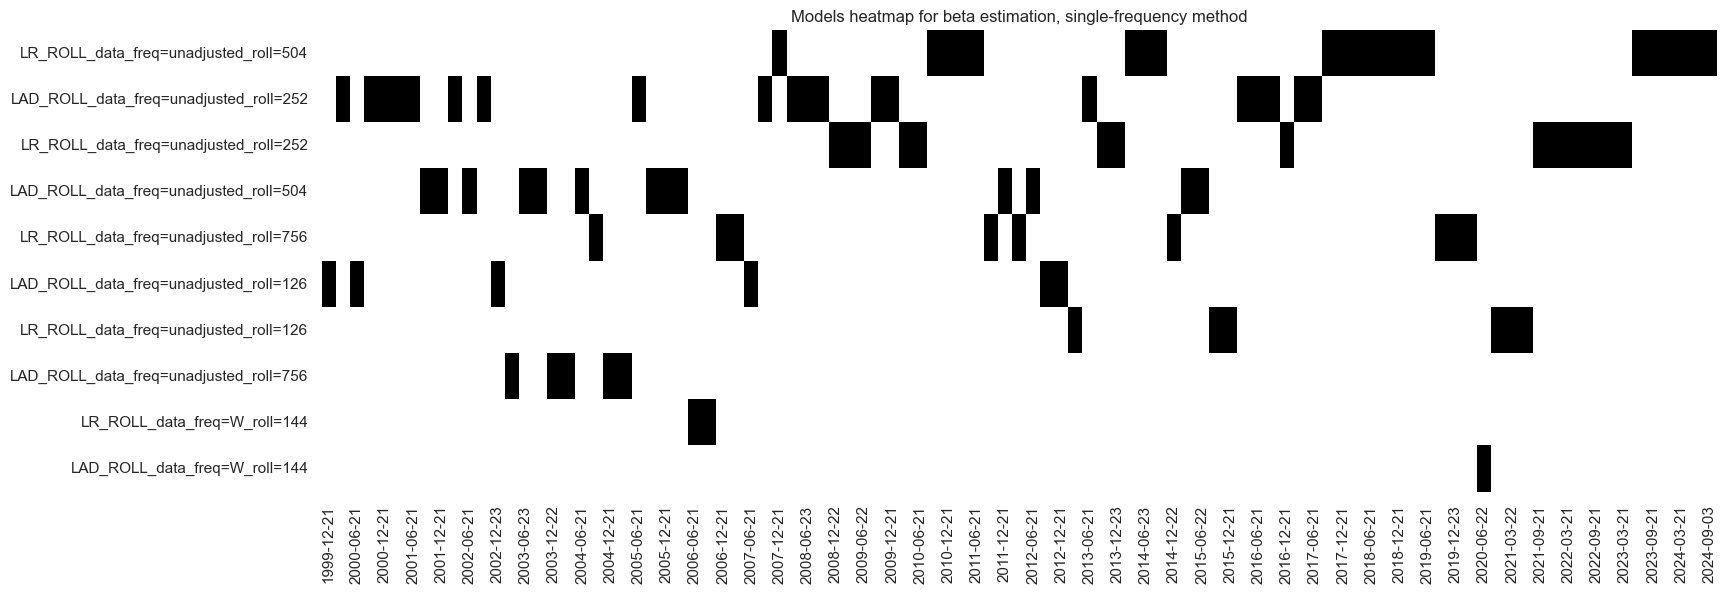

In [17]:
be.models_heatmap(
    name="BETAvGDRB_OQR",
    title="Models heatmap for beta estimation, single-frequency method",
    cap=10,
    figsize=(18, 6),
)

## Learning with dual-frequency optimal regression combinations

The second learning process always averages daily and weekly regression estimates. This approach reflects that these two frequencies have complementary advantages for beta estimation and, hence, should plausibly be considered together. The advantage of the daily frequency is a greater number of observations over time and the ability to use short lookbacks. The advantage of the weekly frequency is less distortion from “time-zone effects”: FX forwards trade liquidly at different hours and, hence, some have only a short overlap with the risk basket assets on any given day.

Again, we consider two standard regression models for estimating betas: a least squares regression and a least absolute deviation regression. In this setting, the frequency is not a hyperparameter, as both types estimate beta based on daily and weekly returns. For each frequency, the learning process selects lookback periods as hyperparameters from the same range of values as for the single-frequency estimates. Cross-validation rules and optimization criterion are the same.

Here we employ `VotingRegressor`, a special method that combines multiple regression models and overperforms the individual models as its estimators.  

In [18]:
models = {
    "LR_VOTE": VotingRegressor(
        [
            (
                "LR1",
                msl.LinearRegressionSystem(
                    min_xs_samples=21, fit_intercept=True, positive=False, data_freq="unadjusted"
                ),
            ),
            (
                "LR2",
                msl.LinearRegressionSystem(
                    min_xs_samples=21, fit_intercept=True, positive=False, data_freq="W"
                ),
            ),
        ]
    ),
    "LAD_VOTE": VotingRegressor(
        [
            (
                "LAD1",
                msl.LADRegressionSystem(
                    min_xs_samples=21, fit_intercept=True, positive=False, data_freq="unadjusted"
                ),
            ),
            (
                "LAD2",
                msl.LADRegressionSystem(
                    min_xs_samples=21, fit_intercept=True, positive=False, data_freq="W"
                ),
            ),
        ]
    ),
}

grid = {
    "LR_VOTE": {
        "LR1__roll": [21, 21 * 3, 21 * 6, 21 * 12, 21 * 24, 21 * 36],
        "LR2__roll": [4 * 6, 4 * 12, 4 * 24, 4 * 36],
    },
    "LAD_VOTE": {
        "LAD1__roll": [21, 21 * 3, 21 * 6, 21 * 12, 21 * 24, 21 * 36],
        "LAD2__roll": [4 * 6, 4 * 12, 4 * 24, 4 * 36],
    },
}

As for the the first approach, the `estimate_beta` function produces betas and hedged returns by learning using the `models` and `grid` dictionaries specified in the cell above, the `ExpandingKFoldPanelSplit` as `inner_splitter` and `eval_score` as scorer (The criterion for optimizing models and hyperparameters is the negative of the mean absolute correlation of returns with the benchmark, i.e., the global directional risk basket return, specified above). 

In [19]:
%%time
# Produce betas and hedged returns by learning

be.estimate_beta(
    beta_xcat="BETAvGDRB_DF",
    hedged_return_xcat="FXXRHvGDRB_DF",
    inner_splitters=inner_splitter,
    scorers=eval_score,
    models=models,
    hyperparameters=grid,
    min_cids=1,
    min_periods=21 * 12,
    est_freq="Q",  # Change to "M", "W" or "D" if more computational resources are available
    n_jobs_outer=12,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 23min 28s


The "heatmap" displays the actual selected model: a range of different model versions qualified as optimal over time. The learning process historically prefers the outlier-resilient least absolute distance regressor. Towards the end of the sample period, the preferred model became a least-squares regressor with a 1-year lookback for the daily data and a 2-year lookback for the weekly data. The learning process also preferred longer lookbacks over shorter ones. The weekly frequency lookback has never been less than 2 years and mostly 3 years.

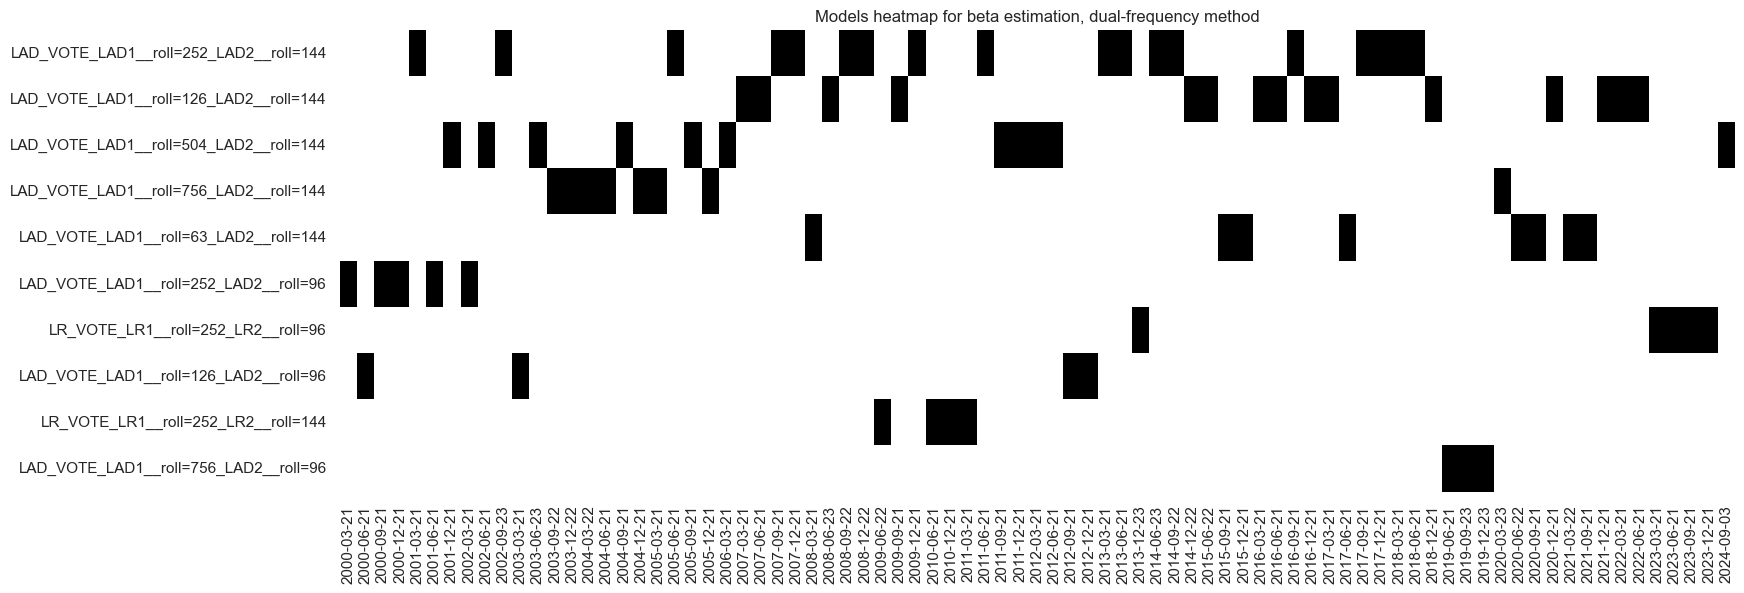

In [20]:
be.models_heatmap(
    name="BETAvGDRB_DF",
    title="Models heatmap for beta estimation, dual-frequency method",
    cap=10,
    figsize=(18, 6),
)

## Learning with separate correlation and volatility estimators

The third learning approach estimates the correlation and volatility of the betas separately, allowing for different lookback periods of these two estimated parameters. The idea behind this approach is that the volatility ratios are more subject to short-term (market conditions), while correlation is more a matter of long-term structural features, such as dependence on capital inflows. 

We use here our custom predictor class `CorrelationVolatilitySystem` written specifically to estimate betas for financial contracts with respect to a benchmark return series. Since an estimated beta can be decomposed into correlation and volatility components, this class aims to estimate these separately, allowing for different lookbacks and weighting schemes for both components. 

The hyperparameters of the volatility ratio estimates are the return frequency (daily and weekly), the time-weighting (simple rolling or exponential moving averages), and the lookback, which is between 5 days and 1 year for daily and between 4 weeks and 1 year for the weekly frequency. The hyperparameters for the correlation are the frequency (daily and weekly), the correlation type (Pearson and Spearman), and the lookback, which is which is between 1 and 5 years.

In [21]:
models = {
    "CORRVOL": msl.CorrelationVolatilitySystem(
        min_xs_samples=21,
    ),
}
grid = {
    "CORRVOL": [
        {
            "correlation_lookback": [
                21 * 12,
                21 * 12 * 2,
                21 * 12 * 5,
            ],
            "correlation_type": ["pearson", "spearman"],
            "volatility_lookback": [5, 10, 21, 21 * 3, 21 * 6, 21 * 12],
            "volatility_window_type": ["exponential", "rolling"],
            "data_freq": ["unadjusted"],
        },
        {
            "correlation_lookback": [4 * 12, 4 * 12 * 2, 4 * 12 * 5],
            "correlation_type": ["pearson", "spearman"],
            "volatility_lookback": [4, 4 * 3, 4 * 6, 4 * 12],
            "volatility_window_type": ["exponential", "rolling"],
            "data_freq": ["W"],
        },
    ]
}

As for the the first two approaches, the `estimate_beta()` function produces betas and hedged returns by learning using the `models` and `grid` dictionaries specified in the cell above, the `ExpandingKFoldPanelSplit` as `inner_splitter` and `eval_score` as the scorer.

In [22]:
%%time
# Produce betas and hedged returns by learning

be.estimate_beta(
    beta_xcat="BETAvGDRB_CV",
    hedged_return_xcat="FXXRHvGDRB_CV",
    inner_splitters=inner_splitter,
    scorers=eval_score,
    models=models,
    hyperparameters=grid,
    min_cids=1,
    min_periods=21 * 12,
    est_freq="Q",  # Change to "Q" if time is an important factor
    n_jobs_outer=12,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 22min 27s


The preferred model at the end of the sample period uses daily frequency returns with a 2-year lookback for a Pearson correlation coefficient and a 1-year rolling lookback window for volatility ratios. This method generally prefers daily over weekly-frequency returns data.

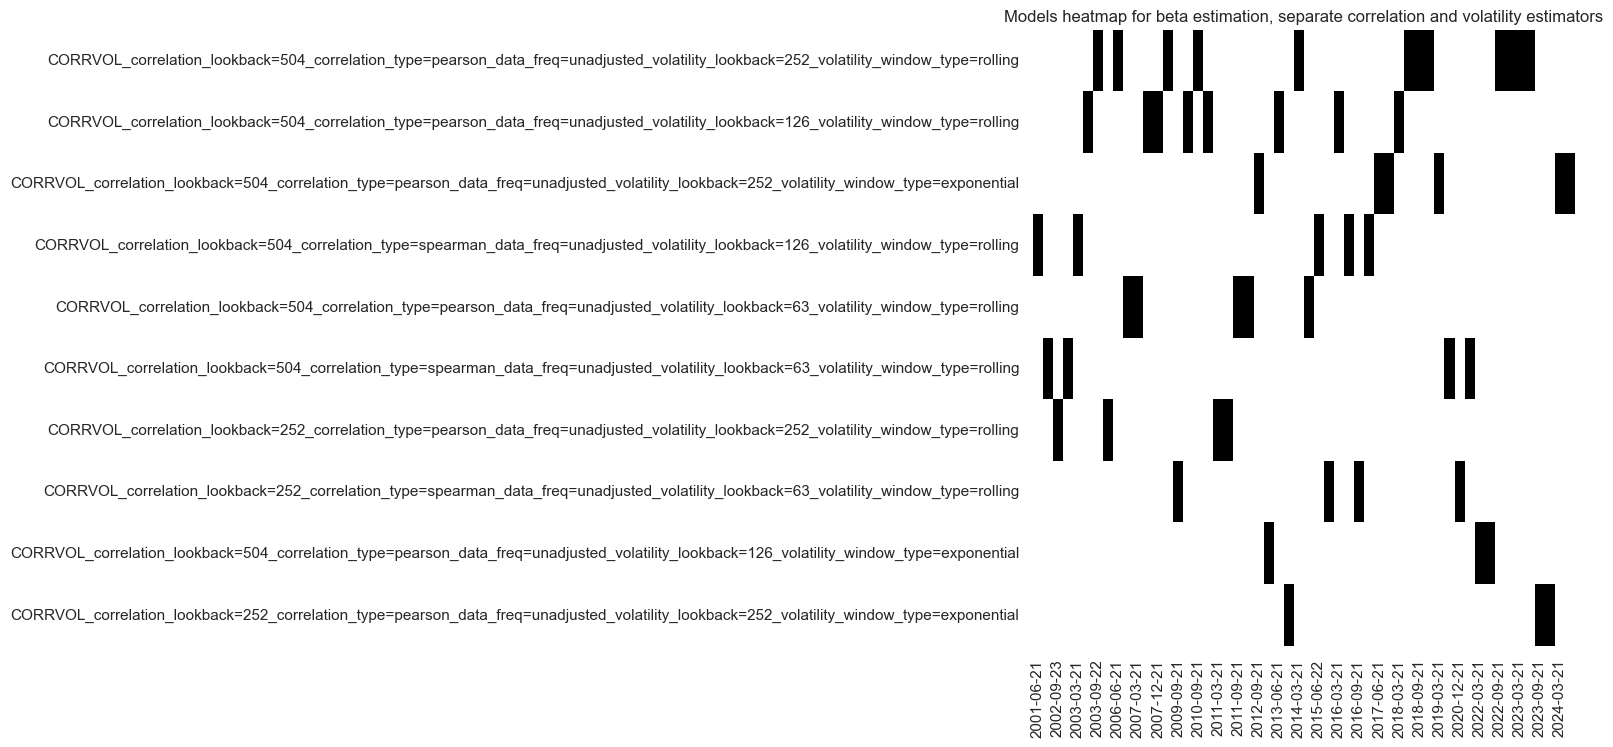

In [23]:
be.models_heatmap(
    name="BETAvGDRB_CV",
    title="Models heatmap for beta estimation, separate correlation and volatility estimators",
    cap=10,
    figsize=(7, 8),
)

# Beta evaluation

Estimated betas and out-of-sample hedged returns derived from beta estimation processes are collected in a temporary dataframe and then concatenated with the main dataframe.

In [30]:
dfa = msm.types.QuantamentalDataFrame(be.get_betas())
dfx = msm.update_df(msm.types.QuantamentalDataFrame(dfx), dfa)

dfa = msm.types.QuantamentalDataFrame(be.get_hedged_returns())
dfx = msm.update_df(dfx, dfa)

The macrosynergy package provides two useful functions, [`view_ranges()`](https://macrosynergy.com/academy/notebooks/introduction-to-macrosynergy-package/#visualize-panel-distributions-with-view-ranges) and [`view_timelines()`](https://macrosynergy.com/academy/notebooks/introduction-to-macrosynergy-package/#visualize-panel-time-series-with-view-timelines). 
The former displays a barplot that focuses on means and standard deviations of one or more categories across sections for a given sample period (in the plot below for the estimated beta ranges for EM FX forwards since 1999, single -frequency regression learning)

The latter facilitates convenient data visualization for selected indicators and cross-sections plotting time series of selected beta estimates for selected cross-sections.

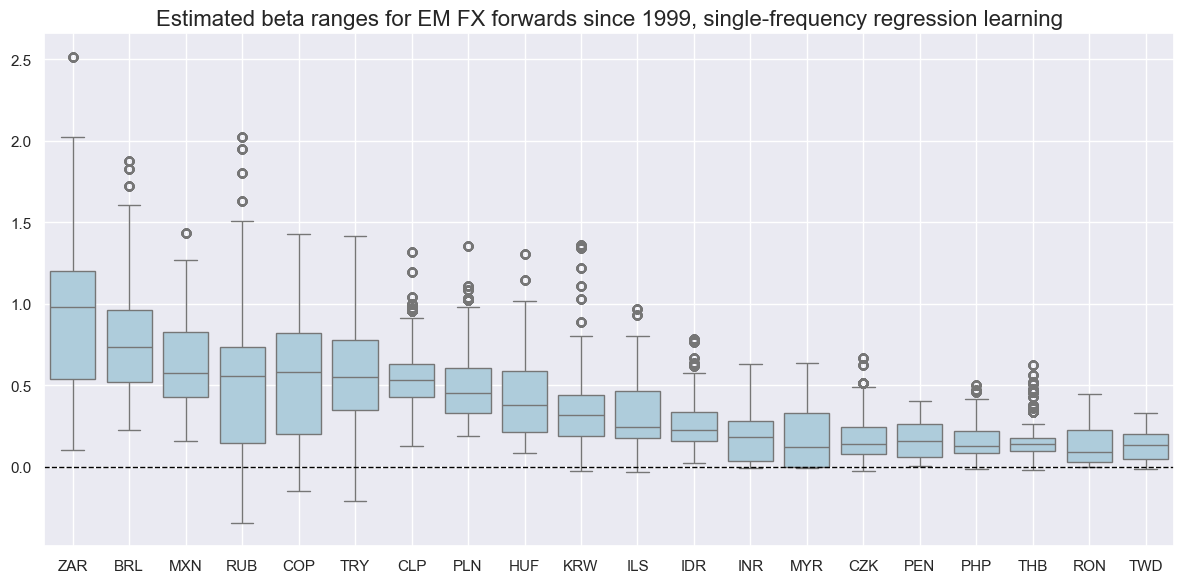

In [31]:
cidx = cids_emfx
sdate = "1999-01-01"

msp.view_ranges(
    dfx,
    xcats=["BETAvGDRB_OQR"],
    cids=cidx,
    start=sdate,
    sort_cids_by="mean",
    title="Estimated beta ranges for EM FX forwards since 1999, single-frequency regression learning",
    size=(12, 6),
    kind="box",
)

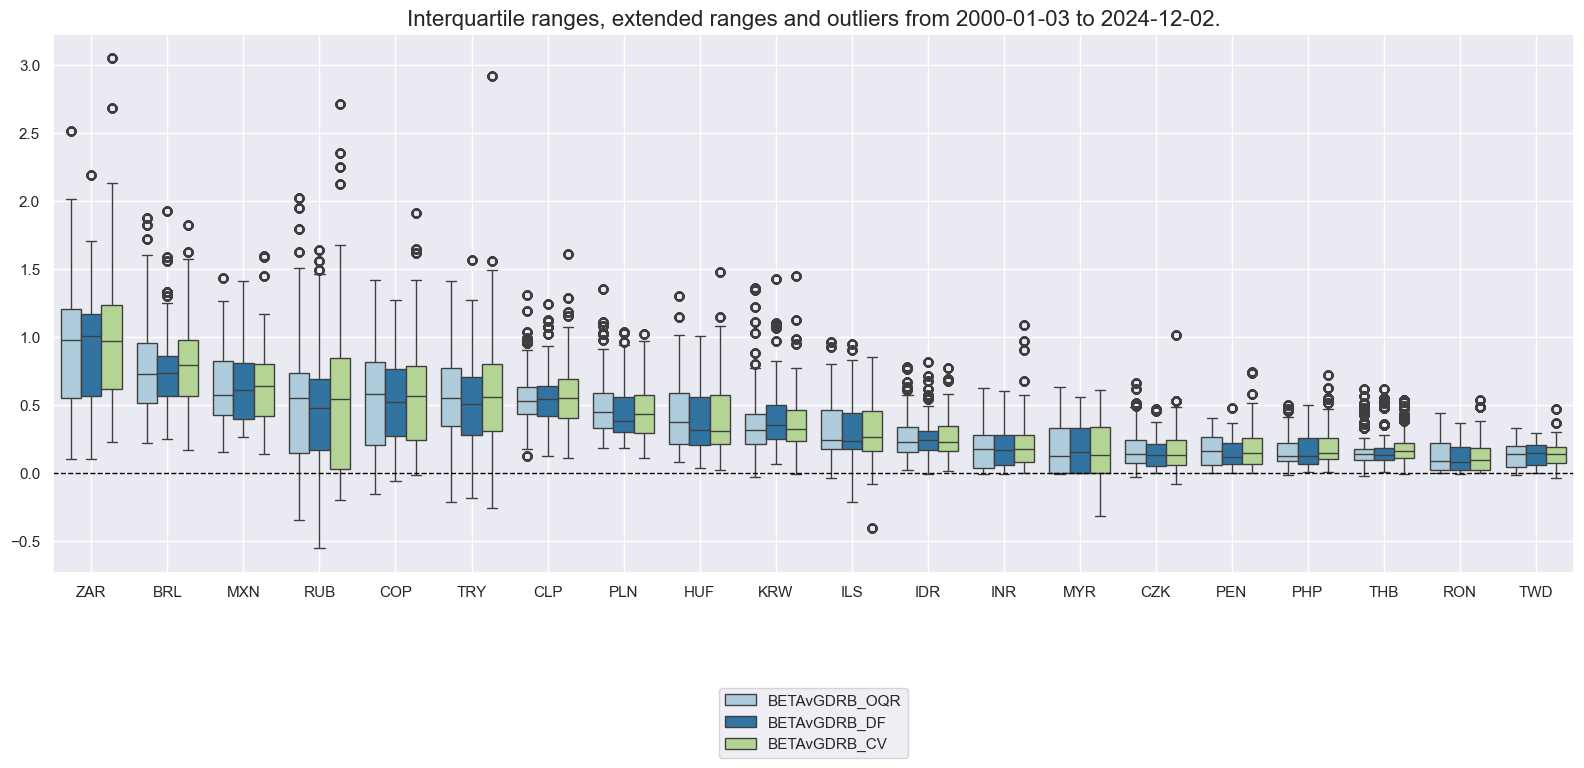

In [32]:
cidx = cids_emfx
sdate = "2000-01-01"

msp.view_ranges(
    dfx,
    xcats=["BETAvGDRB_OQR", "BETAvGDRB_DF", "BETAvGDRB_CV"],
    cids=cidx,
    start=sdate,
    sort_cids_by="mean",
    kind="box",
)

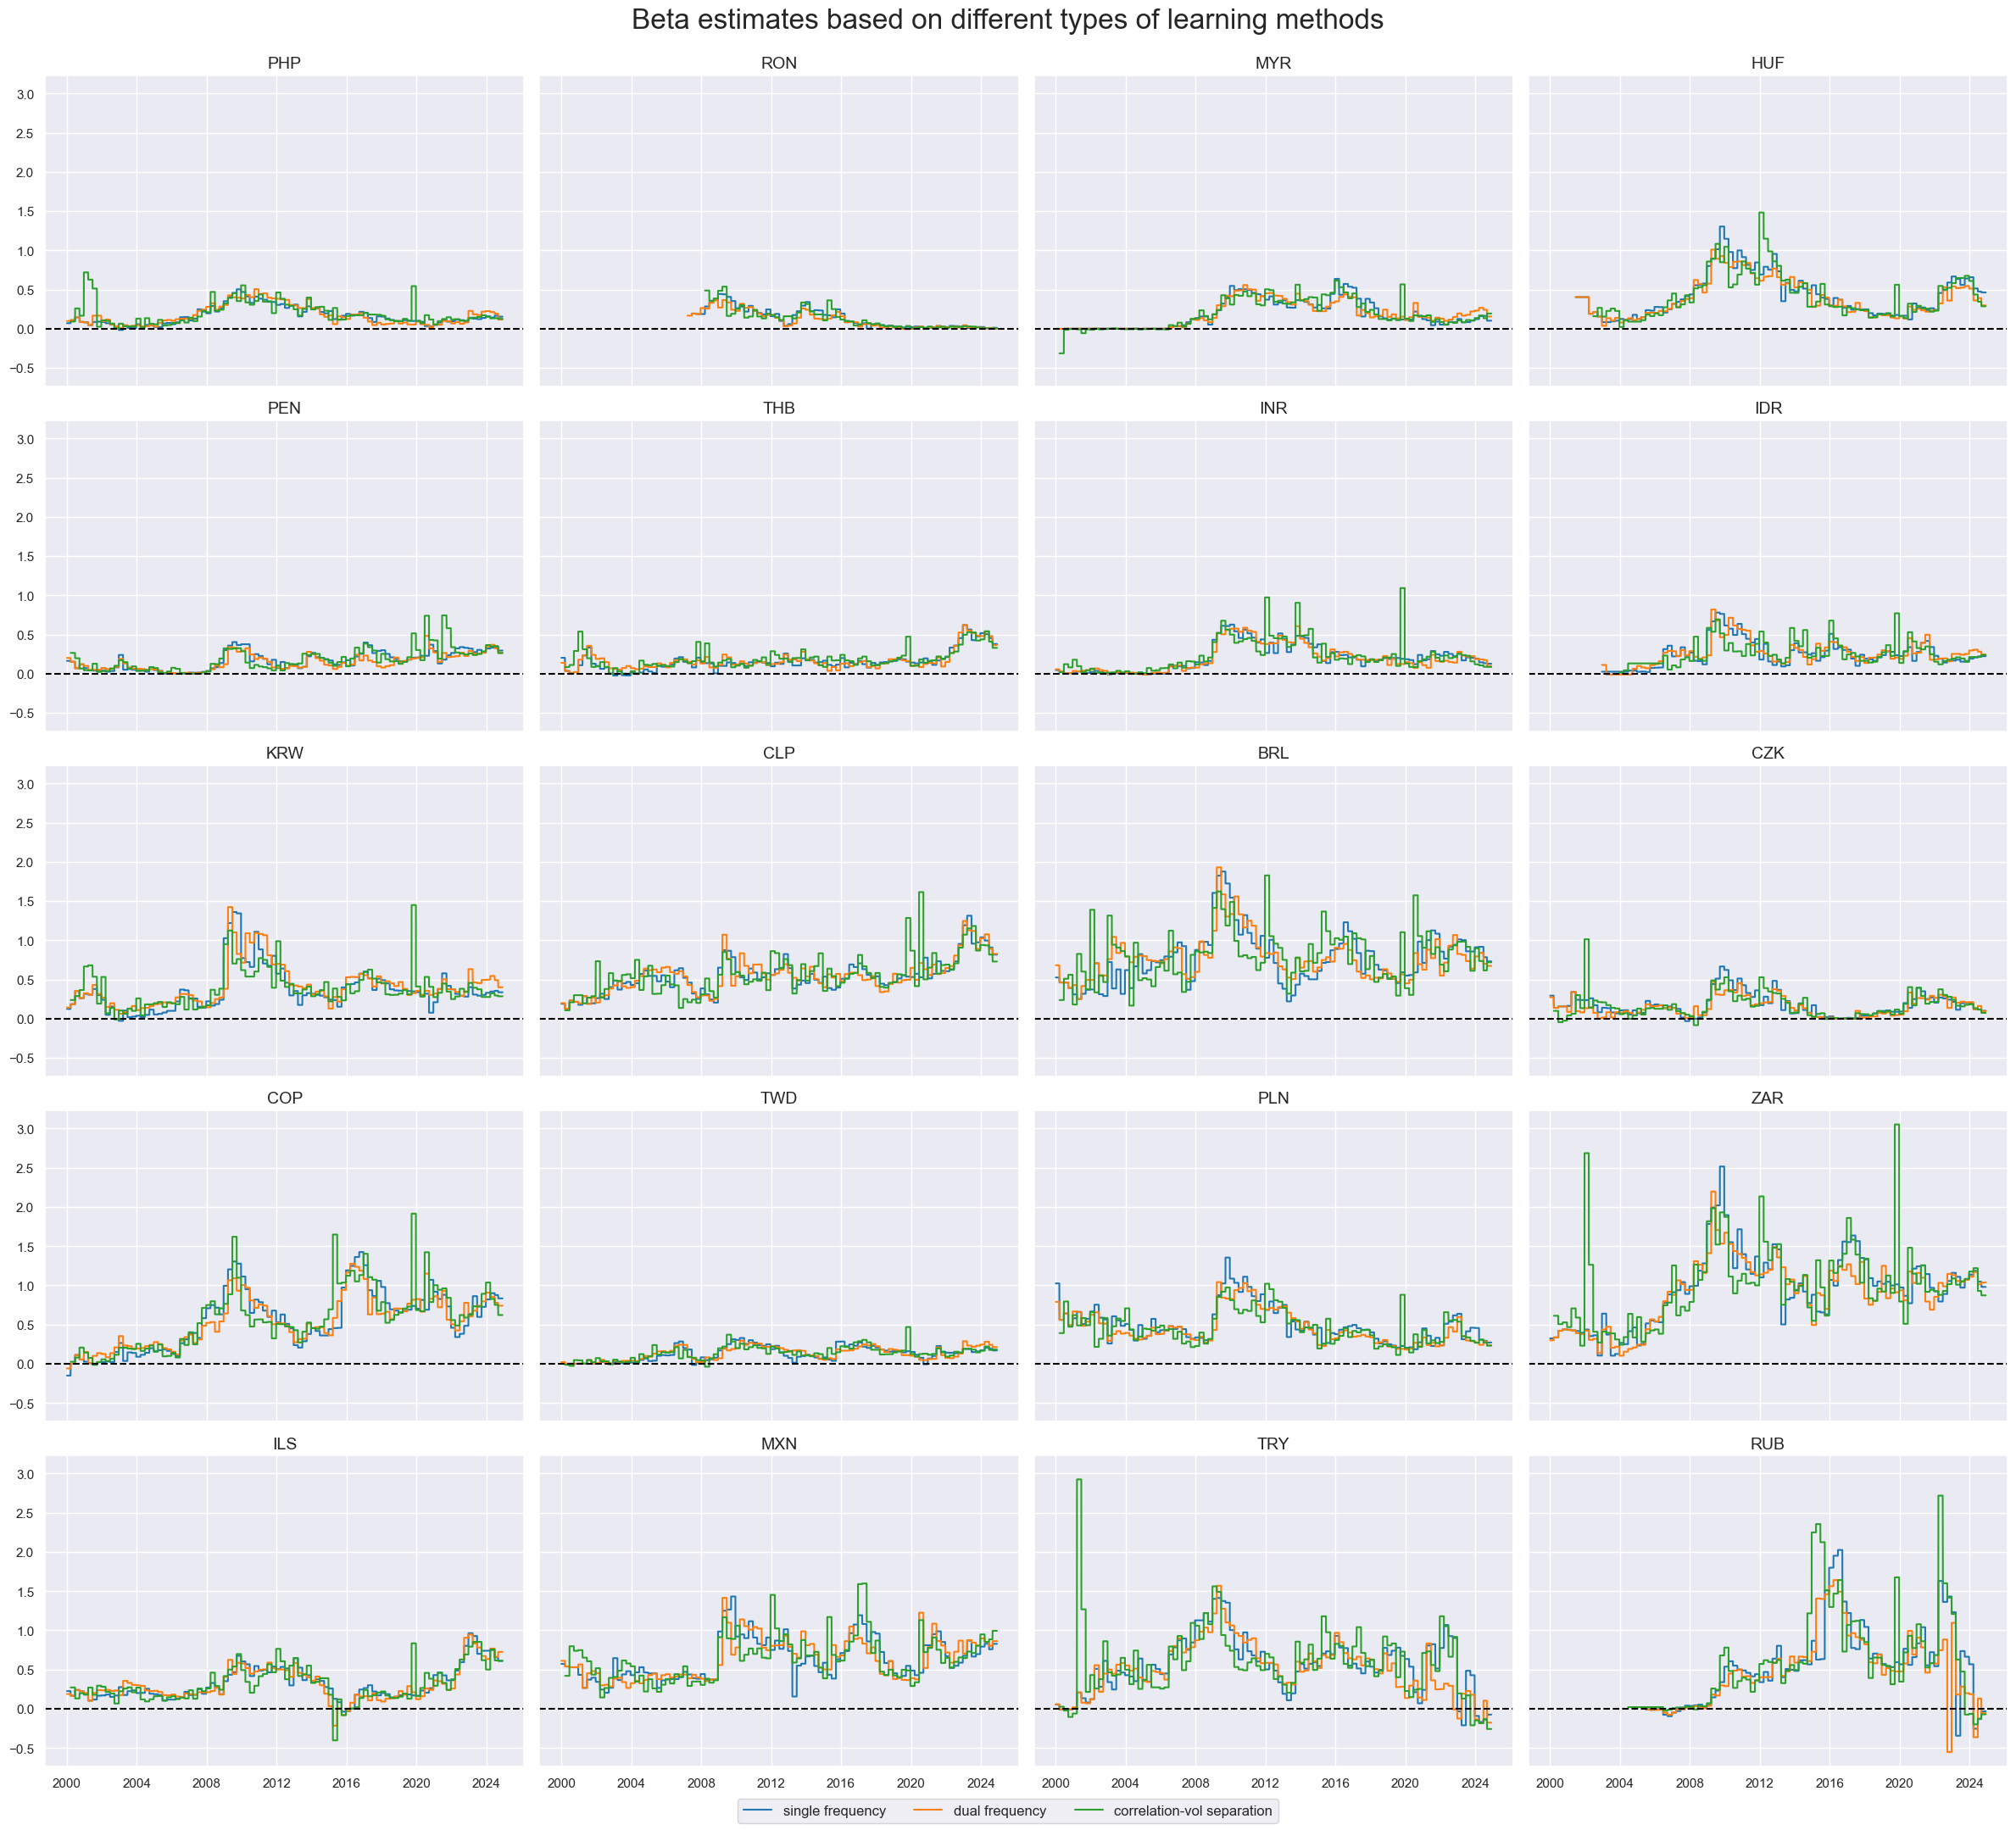

In [33]:
cidx = cids_emfx
sdate = "2000-01-01"

msp.view_timelines(
    df=dfx,
    xcats=["BETAvGDRB_OQR", "BETAvGDRB_DF", "BETAvGDRB_CV"],
    cids=cidx,
    start=sdate,
    cumsum=False,
    ncol=4,
    aspect=1.4,
    same_y=True,
    title="Beta estimates based on different types of learning methods",
    title_fontsize=24,
    xcat_labels=[
        "single frequency",
        "dual frequency",
        "correlation-vol separation",
    ],
)

`evaluate_hedged_returns()` returns a table of average absolute correlations between the benchmark return and the computed hedged returns within the class instance, over all cross-sections in the panel. Additionally, the correlation table displays the same results for the unhedged return specified in the class instance for comparison purposes.

In [34]:
%%time
be.evaluate_hedged_returns(
    correlation_types=["pearson"],
    freqs=["M"],
    cids=cids_emfx,
    start="1999-01-01",
    blacklist=fxblack,
)

Wall time: 2.47 s


pearson
benchmark return return category frequency          
GLB_DRBXR_NSA    FXXRHvGDRB_OQR  M          0.136261
                 FXXRHvGDRB_DF   M          0.135395
                 FXXRHvGDRB_CV   M          0.129064
                 FXXR_NSA        M          0.395805

# Beta application: hedged real carry strategy

## Signal creation and review

The cell below calculates the performance emerging markets FX forward returns and carries before and after hedging using the learning methods employed above.


In [35]:
# Hedged real carry calculation

cidx = cids_emfx
calcs = [
    "FXCRRW =  FXCRR_NSA.clip(-15, 15)",  # for winsorizing
    # calculate (winsorized) hedged FX carry, OLS vs LAD
    "FXCRRHvGDRB_OQR = FXCRR_NSA - BETAvGDRB_OQR * iGLB_DRBCRR_NSA ",
    "FXCRRHvGDRB_OQRW =  FXCRRHvGDRB_OQR.clip(-15, 15)",
    # calculate (winsorized) hedged FX carry, dual frequency
    "FXCRRHvGDRB_DF = FXCRR_NSA - BETAvGDRB_DF * iGLB_DRBCRR_NSA ",
    "FXCRRHvGDRB_DFW =  FXCRRHvGDRB_DF.clip(-15, 15)",
    # calculate (winsorized) hedged FX carry, separate correlation and volatility estimation
    "FXCRRHvGDRB_CV = FXCRR_NSA - BETAvGDRB_CV * iGLB_DRBCRR_NSA ",
    "FXCRRHvGDRB_CVW =  FXCRRHvGDRB_CV.clip(-15, 15)",
    # blacklist return series
    "FXXR_NSABL = FXXR_NSA",
    "FXXRHvGDRB_OQRBL = FXXRHvGDRB_OQR",
    "FXXRHvGDRB_DFBL = FXXRHvGDRB_DF",
    "FXXRHvGDRB_CVBL = FXXRHvGDRB_CV",
]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx, blacklist=fxblack)
dfx = msm.update_df(dfx, dfa)

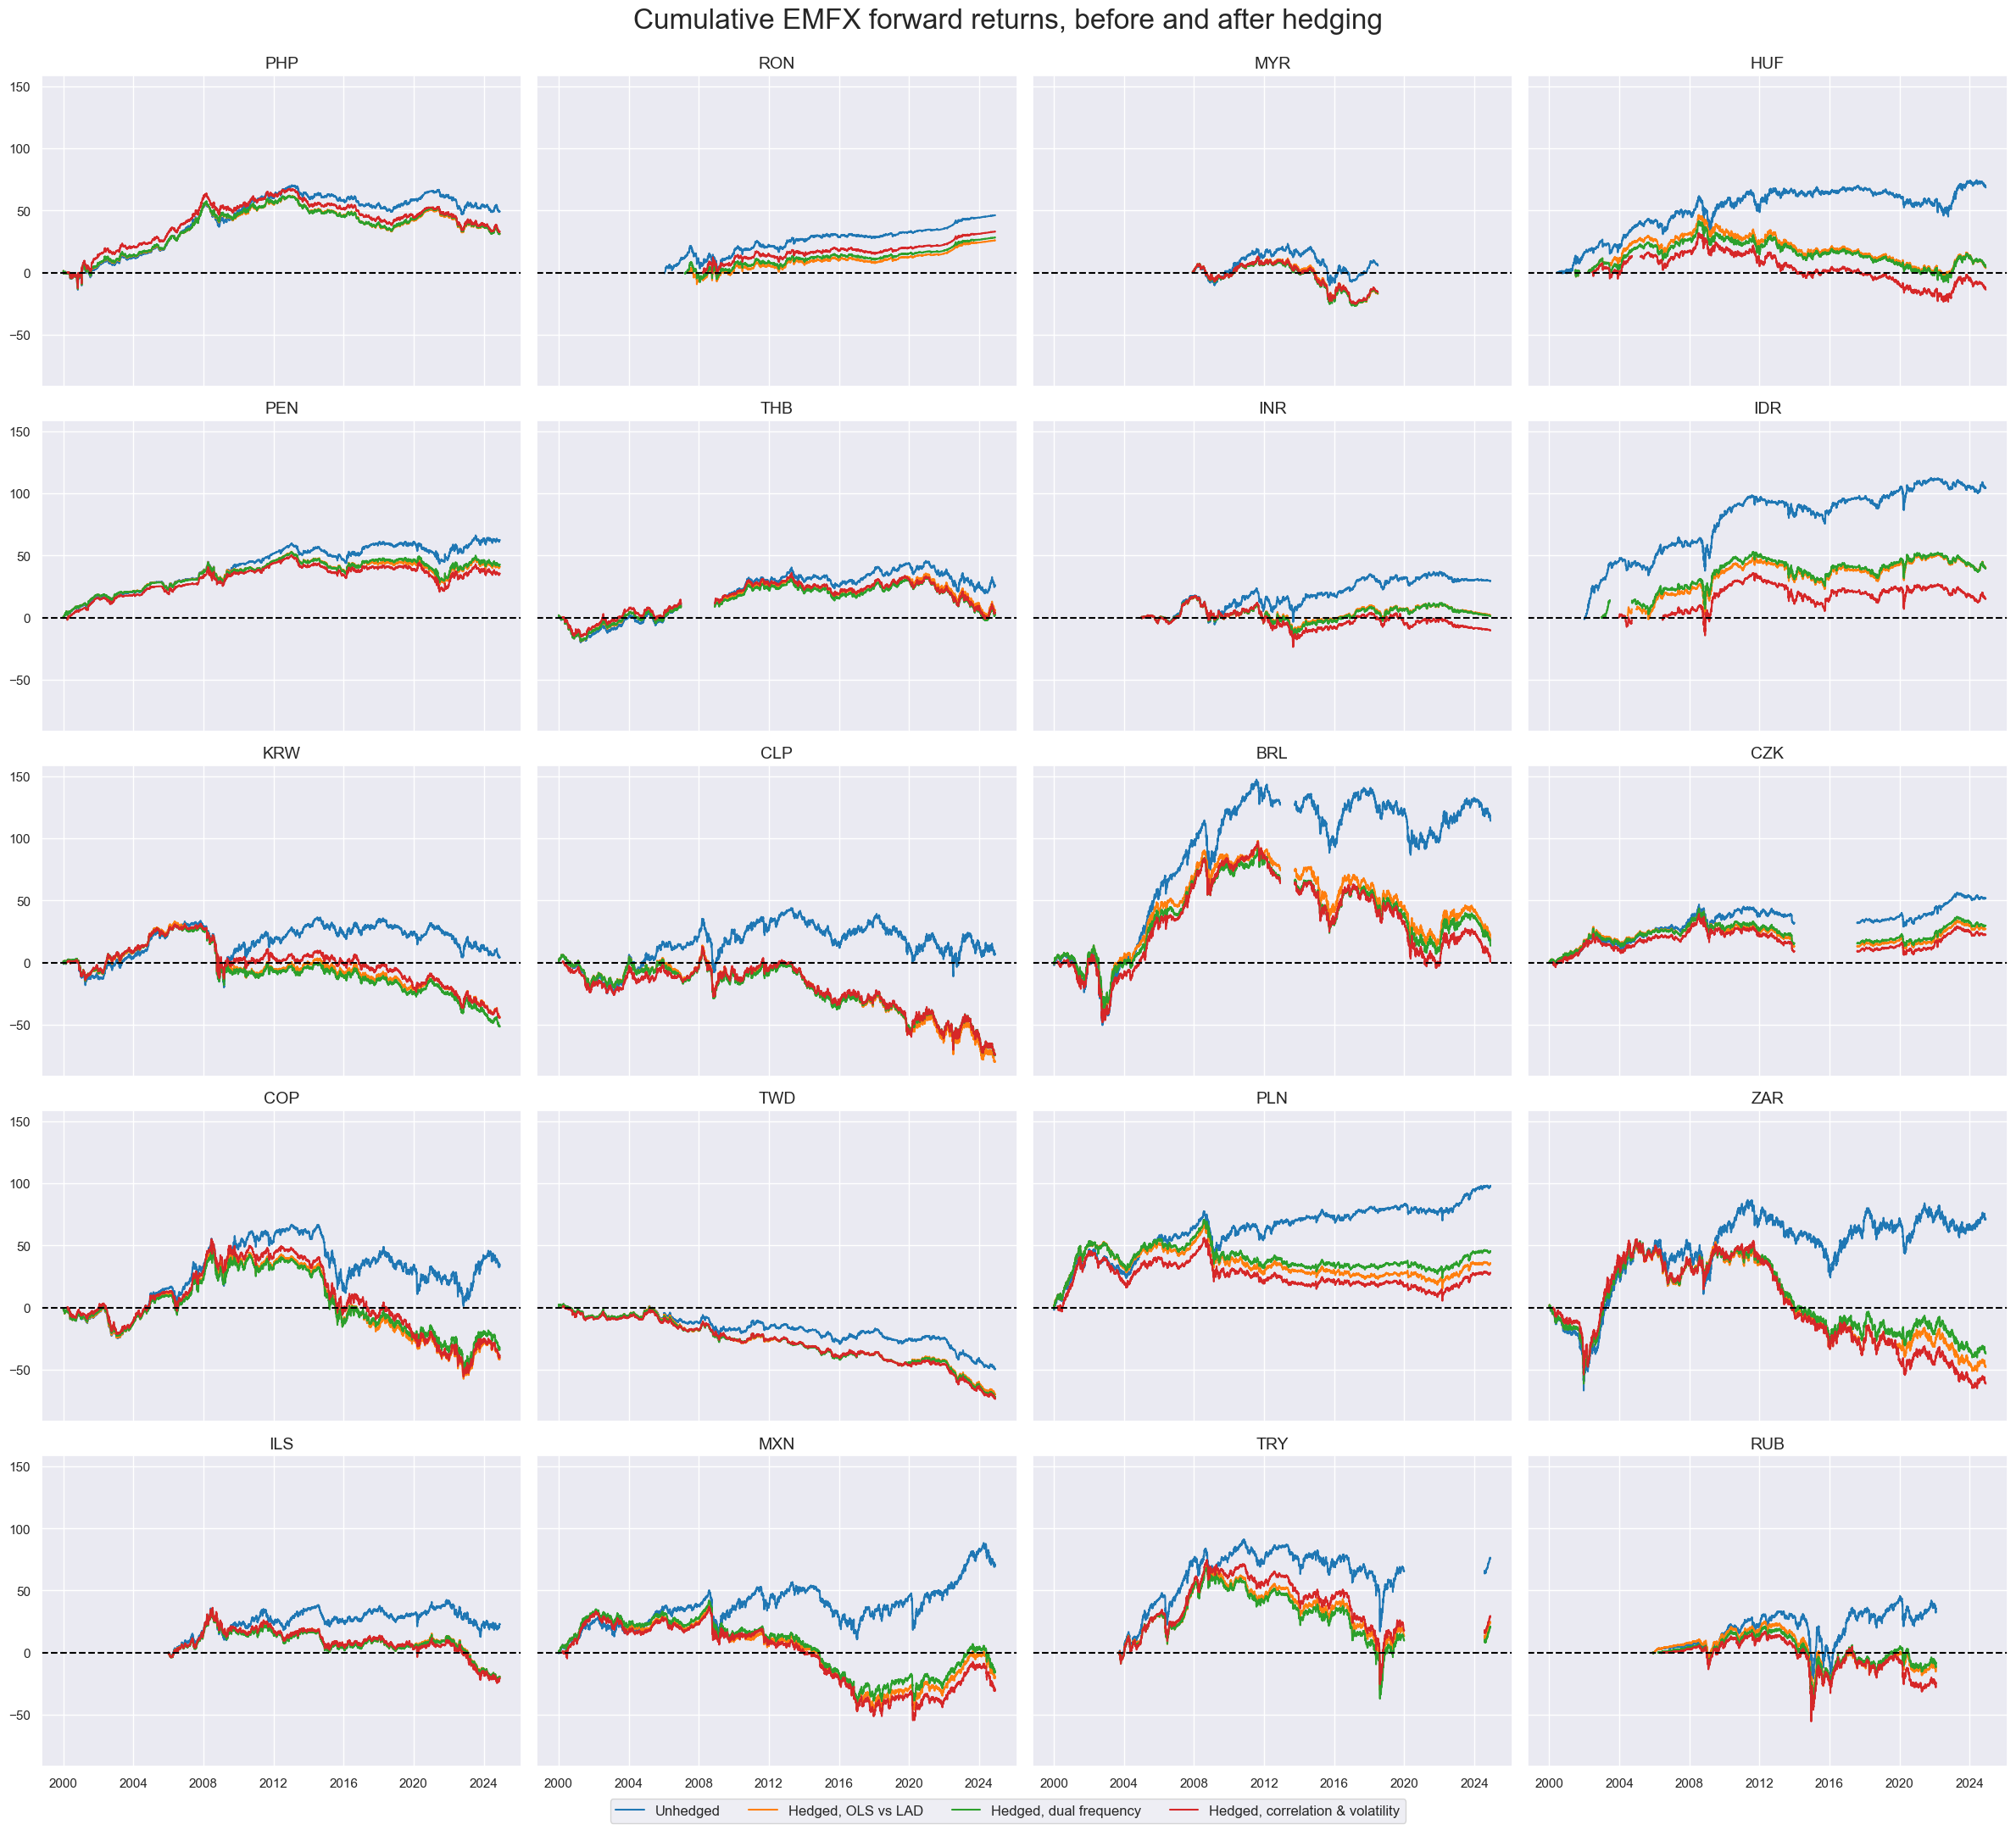

In [36]:
cidx = cids_emfx
sdate = "2000-01-01"

msp.view_timelines(
    df=dfx,
    xcats=["FXXR_NSABL", "FXXRHvGDRB_OQRBL", "FXXRHvGDRB_DFBL", "FXXRHvGDRB_CVBL"],
    xcat_labels=[
        "Unhedged",
        "Hedged, OLS vs LAD",
        "Hedged, dual frequency",
        "Hedged, correlation & volatility",
    ],
    cids=cidx,
    start=sdate,
    cumsum=True,
    ncol=4,
    aspect=1.4,
    same_y=True,
    title="Cumulative EMFX forward returns, before and after hedging",
    title_fontsize=24,
)

Hedging materially alters real carry signals. It does not only reduce the position-specific real carry of longs on high-beta EM currencies but also increases the volatility of carry estimates because those now depend on changing correlations and return volatility rations.

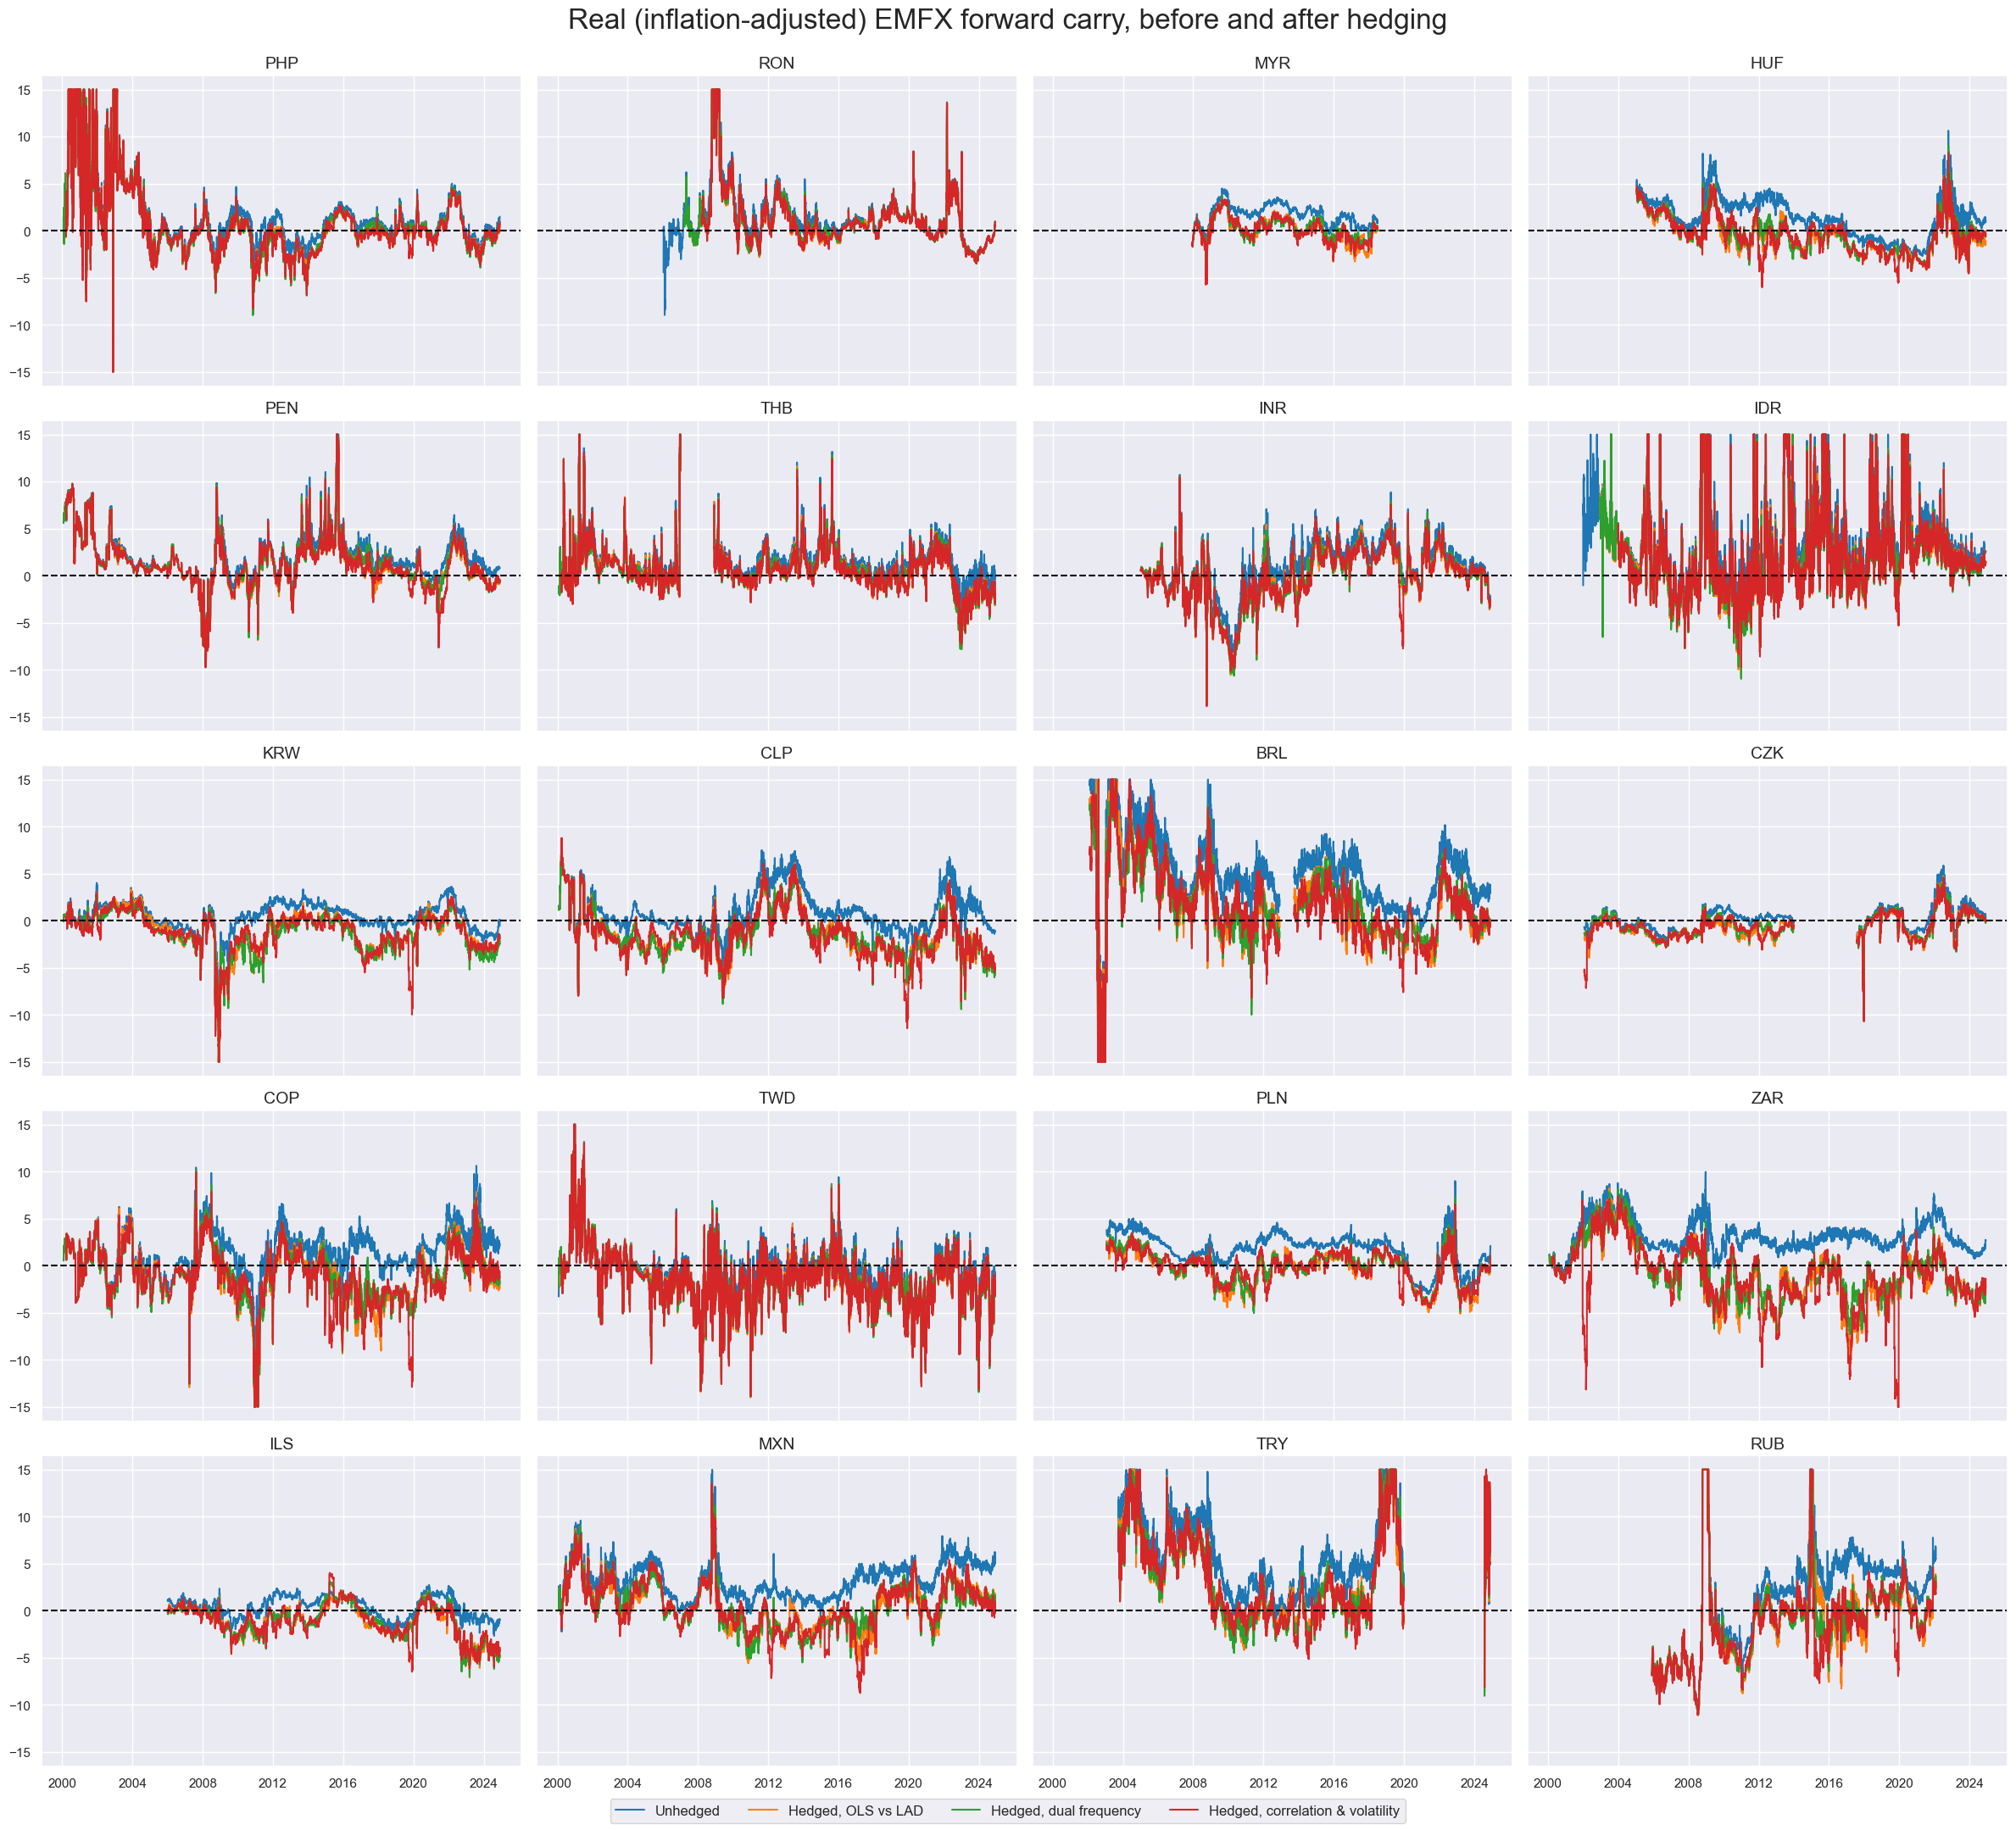

In [37]:
msp.view_timelines(
    df=dfx,
    xcats=["FXCRRW", "FXCRRHvGDRB_OQRW", "FXCRRHvGDRB_DFW", "FXCRRHvGDRB_CVW"],
    xcat_labels=[
        "Unhedged",
        "Hedged, OLS vs LAD",
        "Hedged, dual frequency",
        "Hedged, correlation & volatility",
    ],
    cids=cidx,
    start=sdate,
    cumsum=False,
    ncol=4,
    aspect=1.4,
    same_y=True,
    title="Real (inflation-adjusted) EMFX forward carry, before and after hedging",
    title_fontsize=24,
)

## Value check

### Specs and panel tests

This is the most crucial part of the analysis: evaluating macro trading signals meaningfully is complex and requires multiple steps, as discussed in the post ["Evaluating macro trading signals in three simple steps"](https://macrosynergy.com/research/evaluating-macro-trading-signals-in-three-simple-steps/). 

The approach involves assessing the quality of the signals through three essential steps:

- __Panel correlation:__ This step visualizes and quantifies the relationships between macro signals (features) and subsequent returns (targets) across countries or currency areas. An important metric is the significance of forward correlation. This requires a specialized panel test that adjusts the data of the predictive regression for common global influences across countries. This test is a crucial selection criterion for macro signal candidates. It's important that the hypothesized relationship between features and targets is similar across countries and that the country-specific features matter, not just their global averages.
- __Accuracy and correlation robustness:__ Accuracy measures the share of correctly predicted directions of subsequent returns relative to all predictions. It highlights an important aspect of feature-target co-movement and implicitly tests if the signal’s neutral (zero) level has been well chosen. A particularly important metric for macro trading strategies is balanced accuracy, which is the average of the proportions of correctly predicted positive and negative returns. This statistic is immune to past common directional biases in signal and returns. Simple accuracy (and most PnL performance ratios) can be inflated by past strong performances of the traded assets in conjunction with a natural long bias in the signal.
The robustness of accuracy metrics, parametric (Pearson) correlation, and non-parametric (Kendall) correlation should be checked across time periods, cross-sections, and variations of features and returns.
- __Naïve PnL metrics:__ Naïve profit and loss series can be calculated by taking positions in accordance with normalized signals and regularly rebalancing at the beginning of each month, according to signals at the end of the previous month, allowing for a 1-day time-lapse for trading. The trading signals are capped at a maximum of two standard deviations as a reasonable risk limit. A naïve PnL does not consider transaction costs or risk management tools, so it is not a realistic backtest of actual financial returns in a specific institutional setting. However, it provides an objective and undistorted representation of the economic value of the signals.
Performance metrics of naive PnL analysis prominently indicate economic value in the form of risk-adjusted returns, display correlation to global risk benchmarks (such as bond and equity prices), and show consistency over time, avoiding seasonality and concentration of value generation.

To enable consistent and efficient analysis across various hypotheses (to be discussed in future posts), we have developed a custom dictionary named `dict_emfx`. This dictionary is designed with specific keys to streamline data handling and analysis:

- `sigs`: A list of selected, plausible trading signals for comparative analysis. For this hypothesis, the list includes carry signals: ["FXCRRW", "FXCRRHvGDRB_OQRW", "FXCRRHvGDRB_DFW", "FXCRRHvGDRB_CVW"], which correspond to unhedged carry, hedged (single frequency), hedged (dual frequency), and hedged (correlation-vol separation). 
- `targs`: Targets are selected based on specific FX returns we aim to outperform using the signals ["FXXR_NSA", "FXXRHvGDRB_OQR", "FXXRHvGDRB_DF", "FXXRHvGDRB_CV"].
- `cids`: This key identifies the cross-sections for the analysis, in this case, the emerging markets currencies.
- `start`:  The start date for the data period under analysis, set to "2000-01-01".
- `srr`: Short for "Signal Returns Relations," this key is used to compute the relationships between panels of the selected trading signals (`sigs`) and the panels of subsequent returns from the list (`targs`). This key will be populated post-calculations.

These elements are structured to facilitate an organized approach to the analysis, allowing for straightforward comparisons and replication of outcome evaluations across different trading strategies and hypotheses.


In [38]:
sigs = ["FXCRRW", "FXCRRHvGDRB_OQRW", "FXCRRHvGDRB_DFW", "FXCRRHvGDRB_CVW"]  # carry
targs = ["FXXR_NSA", "FXXRHvGDRB_OQR", "FXXRHvGDRB_DF", "FXXRHvGDRB_CV"]  # return
cidx = cids_emfx
sdate = "2000-01-01"

dict_emfx = {
    "sigs": sigs,
    "targs": targs,
    "cidx": cidx,
    "start": sdate,
    "black": fxblack,
    "srr": None,
}

sig_names = [
    "Unhedged",
    "Hedged, single frequency",
    "Hedged, dual frequency",
    "Hedged, correlation-vol separation",
]

Instances of the [`CategoryRelations`](https://macrosynergy.com/academy/notebooks/introduction-to-macrosynergy-package/#investigate-relations-between-panels-with-categoryrelations) class from the `macrosynnergy.panel` package are designed to organize panels of features and targets into formats suitable for analysis. This class provides functionalities for frequency conversion, adding lags, and trimming outliers. The cell below calculates `CategoryRelations` between each signal and each target from the dictionary `dict_emfx`

`multiple_reg_scatter()` method allows comparison of several pairs of two categories relationships side by side, including the strength of the linear association and any potential outliers. By default, it includes a regression line with a 95% confidence interval, which can help assess the significance of the relationship. 

The `prob_est` argument in this context is used to specify which type of estimator to use for calculating the probability of a significant relationship between the feature category and the target category.`prob_est` is `"map"`, which stands for "Macrosynergy panel test". Often, cross-sectional experiences are not independent and subject to common factors. Simply stacking data can lead to “pseudo-replication” and overestimated significance of correlation. A better method is to check significance through panel regression models with period-specific random effects. This technique adjusts targets and features of the predictive regression for common (global) influences. The stronger these global effects, the greater the weight of deviations from the period-mean in the regression. In the presence of dominant global effects, the test for the significance of a feature would rely mainly upon its ability to explain cross-sectional target differences. Conveniently, the method automatically accounts for the similarity of experiences across sections when assessing the significance and, hence, can be applied to a wide variety of features and targets. View a related research post [here](https://research.macrosynergy.com/testing-macro-trading-factors) that provides more information on this approach.

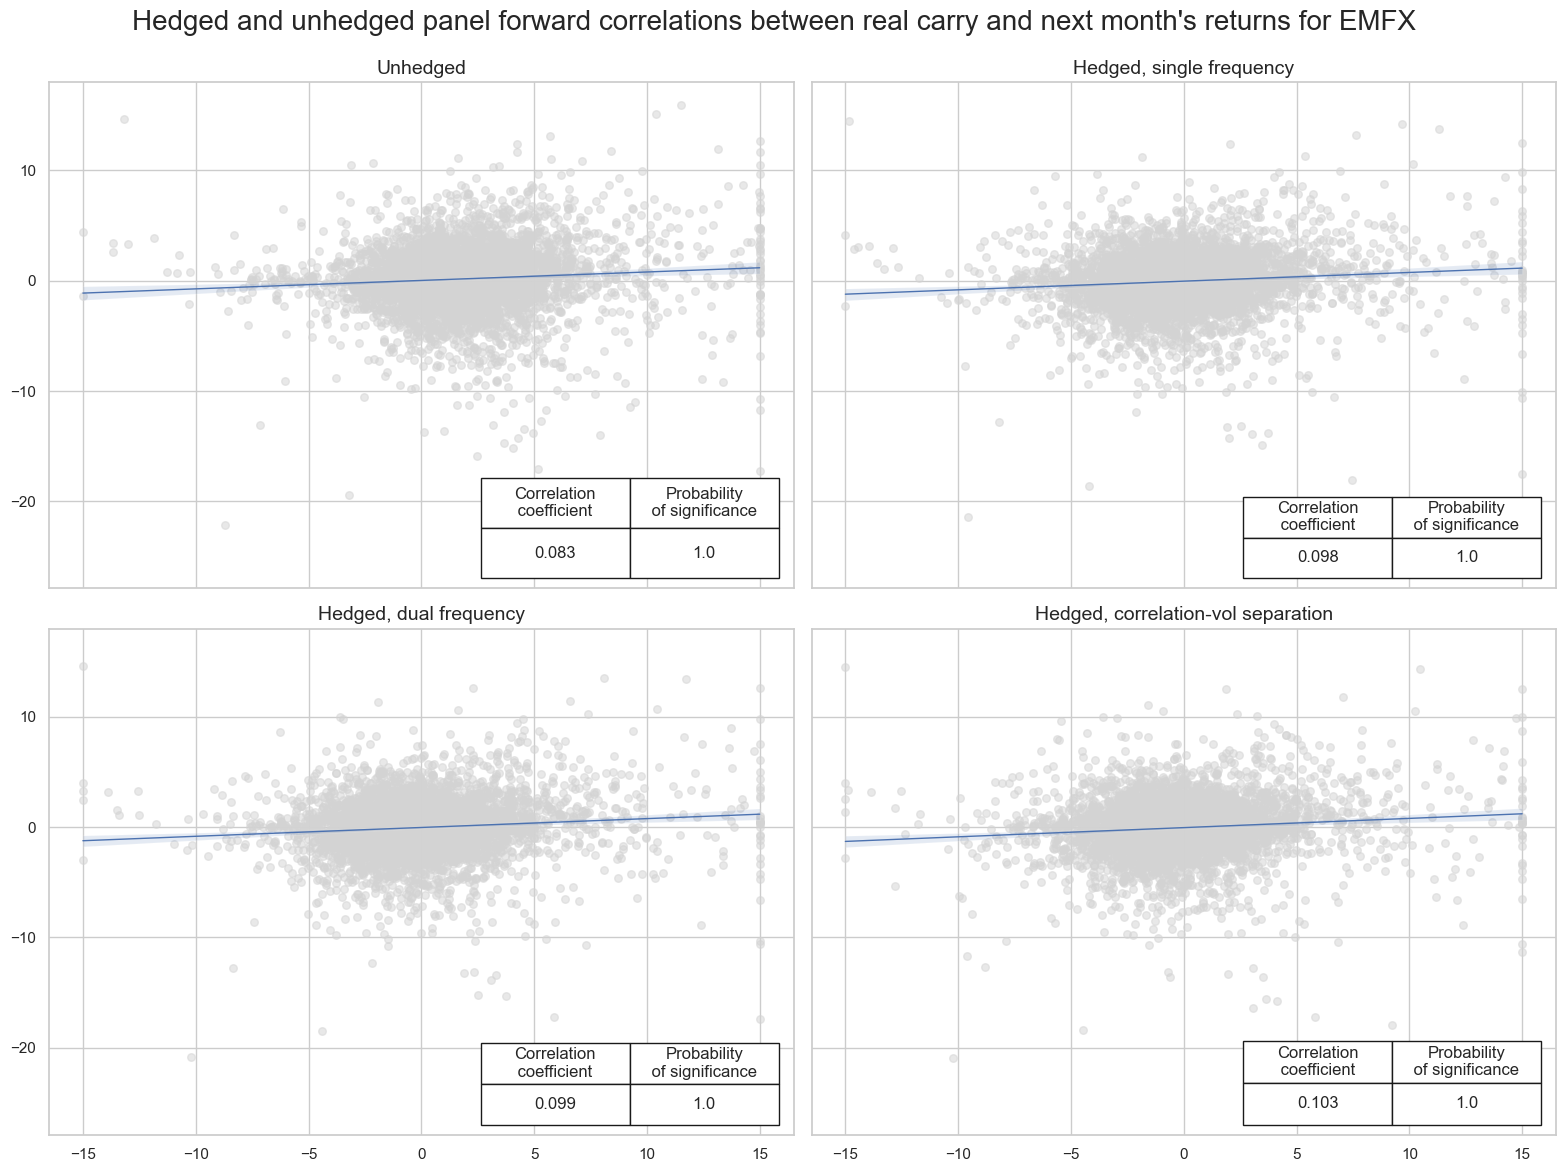

In [39]:
dix = dict_emfx

sigx = dix["sigs"]
targx = dix["targs"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

lcrs = []

for i in range(len(sigx)):
    sig = sigx[i]
    targ = targx[i]
    cr = msp.CategoryRelations(
        dfx,
        xcats=[sig, targ],
        cids=cidx,
        freq="M",
        lag=1,
        xcat_aggs=["last", "sum"],
        start=start,
        blacklist=blax,
    )
    lcrs.append(cr)

msv.multiple_reg_scatter(
    lcrs,
    ncol=2,
    nrow=2,
    title="Hedged and unhedged panel forward correlations between real carry and next month's returns for EMFX",
    xlab=None,
    ylab=None,
    figsize=(16, 12),
    coef_box="lower right",
    prob_est="map",
    subplot_titles=sig_names,
)

### Accuracy

The [`SignalReturnRelations`](https://macrosynergy.com/academy/notebooks/introduction-to-macrosynergy-package/#signalreturnrelations) class of the `macrosynergy.signal` module collects the main positioning factor and its key rivals (or constituents), and brings them into the right format by appropriate frequency conversion (which should correspond to the envisaged trading frequency) and whether the signal is supposed to predict the return positively or negatively. 

In [40]:
dix = dict_emfx

sigx = dix["sigs"]
tarx = dix["targs"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    df=dfx,
    rets=tarx,
    sigs=sigx,
    cids=cidx,
    cosp=True,
    freqs=["M"],
    agg_sigs=["last"],
    start=start,
    blacklist=fxblack,
    slip=1,
    ms_panel_test=True,
)
dix["srr"] = srr

The `multiple_relations_table()` method, part of the `SignalReturnRelations` class within the `macrosynergy.signal` module, facilitates the comparison of multiple signal-return relationships within a single table. This method is particularly useful for evaluating the efficacy of various signals against identical return series across potentially different financial returns and frequencies. The table is structured such that the first column displays the target (financial return), and the second column shows the name of the signal, with `_NEG` appended to indicate a negative relationship to the named return. The table also includes standard columns that conform to established metrics such as accuracy, balanced accuracy, and others, which are detailed in  [MacroSynergy's documentation on summary tables](https://macrosynergy.com/academy/notebooks/introduction-to-macrosynergy-package/#summary-tables). This structured approach allows for an intuitive and comprehensive assessment of signal performance in relation to various financial returns. The code in the following cell formats the standard version of the table, giving the columns more readable names, and selecting the most relevant columns out of all available.

In [41]:
dix = dict_emfx
srr = dix["srr"]

# for column modifications
dict_cols = {
    "accuracy": "Accuracy",
    "bal_accuracy": "Balanced accuracy",
    "pos_sigr": "Share of positive signals",
    "pos_retr": "Share of positive returns",
    "pos_prec": "Positive precision",
    "neg_prec": "Negative precision",
}

tbr = srr.multiple_relations_table().round(3)[list(dict_cols.keys())]
tbr = tbr.reset_index(level=["Aggregation", "Frequency"], drop=True).loc[
    [
        ("FXXR_NSA", "FXCRRW"),
        ("FXXRHvGDRB_OQR", "FXCRRHvGDRB_OQRW"),
        ("FXXRHvGDRB_DF", "FXCRRHvGDRB_DFW"),
        ("FXXRHvGDRB_CV", "FXCRRHvGDRB_CVW"),
    ],
    :,
].reset_index(drop=True)
tbr.index = sig_names
tbr.rename(columns=dict_cols, inplace=True)

# apply style and heading

tbr = tbr.style.format("{:.2f}").set_caption(
    f"Predictive accuracy and correlation of real carry for subsequent monthly returns").set_table_styles(
    [{"selector": "caption", "props": [("text-align", "center"), ("font-weight", "bold"), ("font-size", "17px")]}])

display(tbr)

### Naive PnLs

The [`NaivePnL`](https://macrosynergy.com/academy/notebooks/introduction-to-macrosynergy-package/#naivepnl) class of the `macrosynergy.pnl` module is the basis for calculating simple stylized PnLs for various signals under consideration of correlation benchmarks.

The related [`make_pnl()`](https://macrosynergy.com/academy/notebooks/introduction-to-macrosynergy-package/#make-pnl) method calculates and stores generic PnLs based on a range of signals and their transformations into positions. The positioning options include the choice of trading frequency, z-scoring, simple equal-size long-short positions (-1/1) thresholds to prevent outsized positions, and rebalancing slippage.
The generated PnLs are, however, naive insofar as they do not consider trading costs and plausible risk management restrictions. Also, if a volatility scale is set, this is done so ex-post, mainly for the benefit of plotting different signals' PnLs in a single chart.

A complementary method is [`make_long_pnl()`](https://macrosynergy.com/academy/notebooks/introduction-to-macrosynergy-package/#make-long-pnl), which calculates a "long-only" PnL based on a uniform long position across all markets at all times. This often serves as a benchmark for gauging the benefits of active trading.

Simple cumulative PnLs in the class instance can be plotted with the [`plot_pnls()`](https://macrosynergy.com/academy/notebooks/introduction-to-macrosynergy-package/#plot-pnls) method. They mainly inform on seasonality and stability of value generation under the assumption of negligible transaction costs.

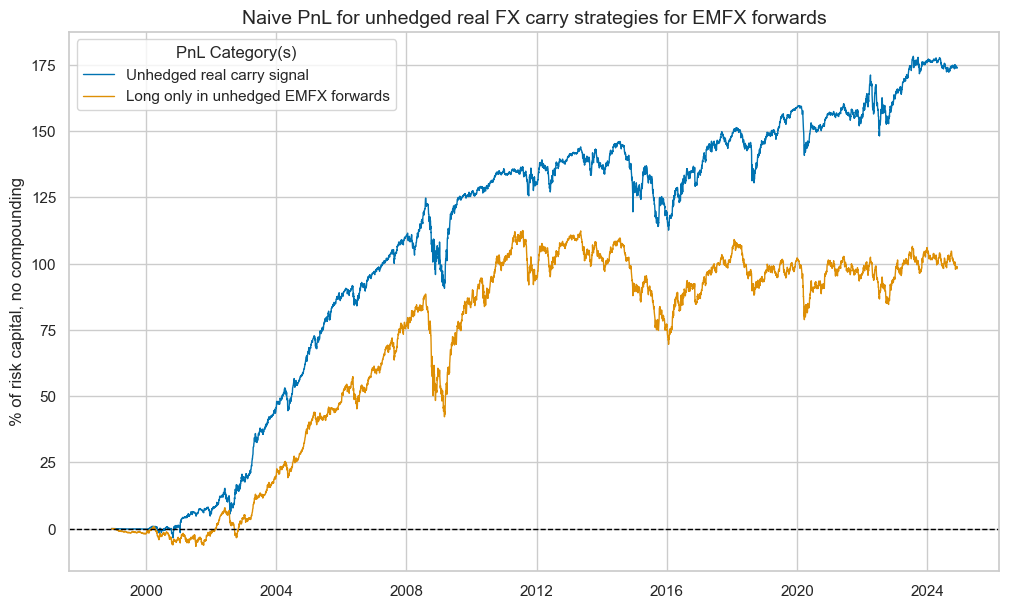

xcat                     PNL_FXCRRW  Long only
Return %                   6.695316   3.777176
St. Dev. %                     10.0       10.0
Sharpe Ratio               0.669532   0.377718
Sortino Ratio              0.948206   0.521915
Max 21-Day Draw %        -17.704236 -26.467465
Max 6-Month Draw %       -30.851879 -38.143636
Peak to Trough Draw %     -34.06048 -46.298769
Top 5% Monthly PnL Share   0.723823   1.157298
USD_EQXR_NSA correl        0.303957   0.367007
EUR_FXXR_NSA correl         0.25848   0.438264
Traded Months                   313        313

In [42]:
dix = dict_emfx

sigx = [dix["sigs"][0]]
targ = dix["targs"][0]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

pnl_uh = msn.NaivePnL(
    df=dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start=start,
    blacklist=blax,
    bms=["USD_EQXR_NSA", "EUR_FXXR_NSA"],
)

pnl_uh.make_pnl(
    sig=sigx[0],
    sig_op="zn_score_pan",
    rebal_freq="monthly",
    neutral="zero",
    rebal_slip=1,
    vol_scale=10,
    thresh=3,
)
pnl_uh.make_long_pnl(vol_scale=10, label="Long only")

pnl_uh.plot_pnls(
    pnl_cats=None,
    title="Naive PnL for unhedged real FX carry strategies for EMFX forwards",
    title_fontsize=14,
    xcat_labels=["Unhedged real carry signal", "Long only in unhedged EMFX forwards"],
)
pnl_uh.evaluate_pnls(["PNL_" + sigx[0], "Long only"])

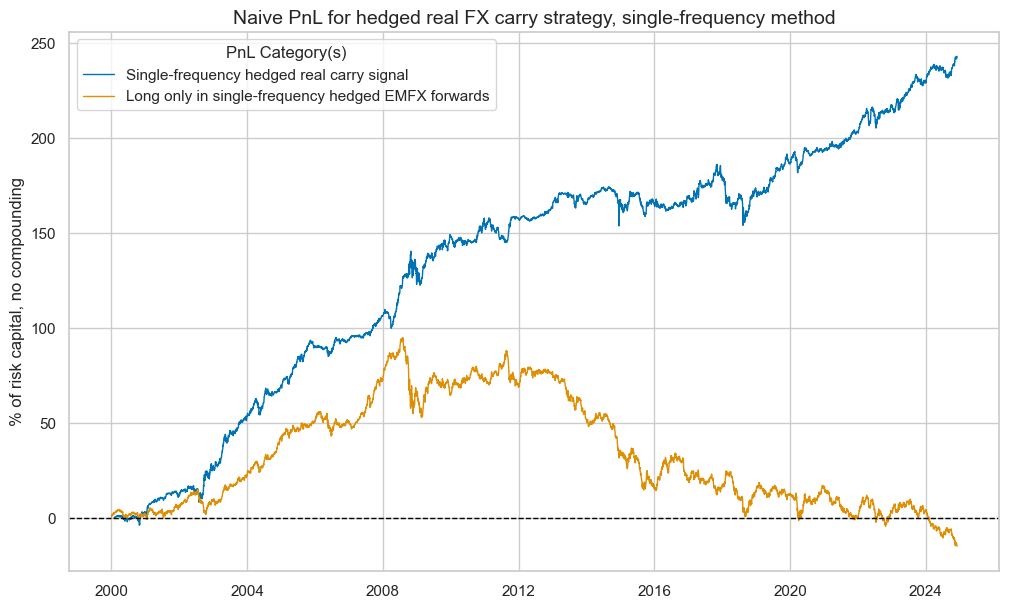

xcat                     PNL_FXCRRHvGDRB_OQRW   Long only
Return %                             9.781258    -0.60084
St. Dev. %                               10.0        10.0
Sharpe Ratio                         0.978126   -0.060084
Sortino Ratio                        1.439523   -0.082331
Max 21-Day Draw %                  -15.371576  -26.162718
Max 6-Month Draw %                 -20.720415  -36.696856
Peak to Trough Draw %              -32.102466 -109.805262
Top 5% Monthly PnL Share               0.4382   -6.647301
USD_EQXR_NSA correl                  0.079936   -0.022875
EUR_FXXR_NSA correl                   -0.0296    0.269568
Traded Months                             300         300

In [43]:
dix = dict_emfx

sigx = [dix["sigs"][1]]
targ = dix["targs"][1]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

pnl_hsf = msn.NaivePnL(
    df=dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start=start,
    blacklist=blax,
    bms=["USD_EQXR_NSA", "EUR_FXXR_NSA"],
)

pnl_hsf.make_pnl(
    sig=sigx[0],
    sig_op="zn_score_pan",
    rebal_freq="monthly",
    neutral="zero",
    rebal_slip=1,
    vol_scale=10,
    thresh=3,
)
pnl_hsf.make_long_pnl(vol_scale=10, label="Long only")

pnl_hsf.plot_pnls(
    pnl_cats=None,
    title="Naive PnL for hedged real FX carry strategy, single-frequency method",
    title_fontsize=14,
    xcat_labels=[
        "Single-frequency hedged real carry signal",
        "Long only in single-frequency hedged EMFX forwards",
    ],
)
pnl_hsf.evaluate_pnls(["PNL_" + sigx[0], "Long only"])

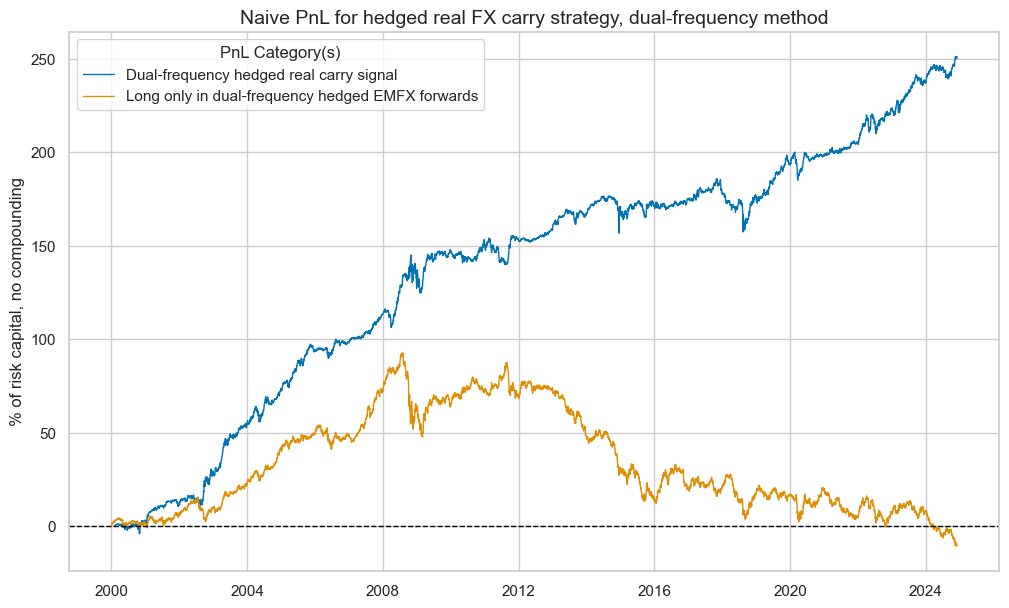

xcat                     PNL_FXCRRHvGDRB_DFW   Long only
Return %                           10.119927   -0.431954
St. Dev. %                              10.0        10.0
Sharpe Ratio                        1.011993   -0.043195
Sortino Ratio                       1.483892   -0.059119
Max 21-Day Draw %                 -15.566435  -26.824633
Max 6-Month Draw %                -19.135729  -38.627507
Peak to Trough Draw %             -28.510182 -103.528347
Top 5% Monthly PnL Share            0.444705   -9.056856
USD_EQXR_NSA correl                 0.093763   -0.000624
EUR_FXXR_NSA correl                -0.010851    0.283714
Traded Months                            300         300

In [44]:
dix = dict_emfx

sigx = [dix["sigs"][2]]
targ = dix["targs"][2]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

pnl_hmf = msn.NaivePnL(
    df=dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start=start,
    blacklist=blax,
    bms=["USD_EQXR_NSA", "EUR_FXXR_NSA"],
)

pnl_hmf.make_pnl(
    sig=sigx[0],
    sig_op="zn_score_pan",
    rebal_freq="monthly",
    neutral="zero",
    rebal_slip=1,
    vol_scale=10,
    thresh=3,
)
pnl_hmf.make_long_pnl(vol_scale=10, label="Long only")

pnl_hmf.plot_pnls(
    pnl_cats=None,
    title="Naive PnL for hedged real FX carry strategy, dual-frequency method",
    title_fontsize=14,
    xcat_labels=[
        "Dual-frequency hedged real carry signal",
        "Long only in dual-frequency hedged EMFX forwards",
    ],
)
pnl_hmf.evaluate_pnls(["PNL_" + sigx[0], "Long only"])

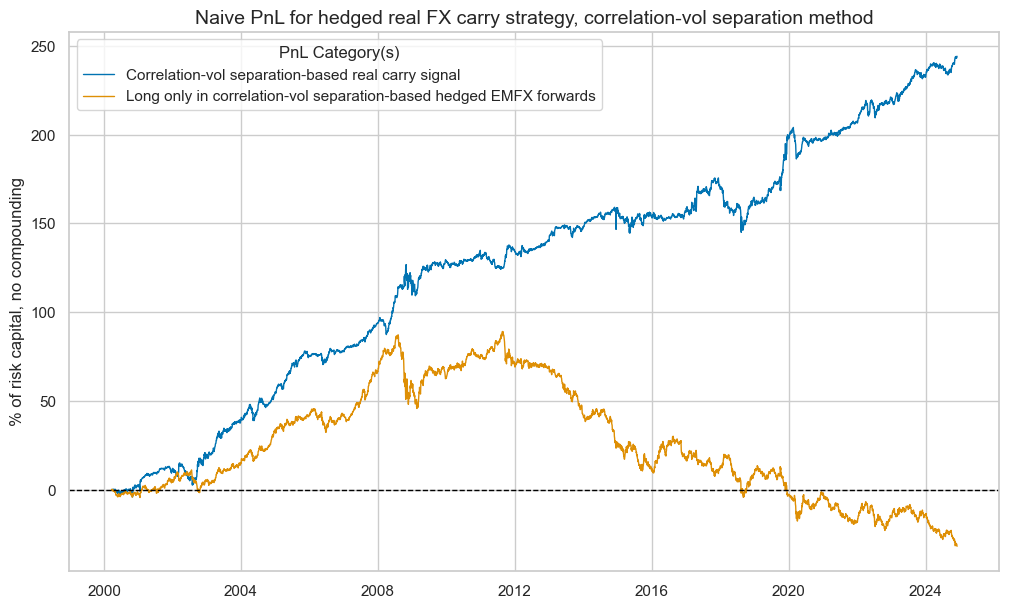

xcat                     PNL_FXCRRHvGDRB_CVW   Long only
Return %                            9.881975   -1.278988
St. Dev. %                              10.0        10.0
Sharpe Ratio                        0.988197   -0.127899
Sortino Ratio                       1.456721   -0.174305
Max 21-Day Draw %                 -16.419715  -25.440026
Max 6-Month Draw %                 -19.36016  -35.980389
Peak to Trough Draw %             -30.609652 -120.820688
Top 5% Monthly PnL Share            0.434752   -3.022319
USD_EQXR_NSA correl                 0.084294   -0.009999
EUR_FXXR_NSA correl                -0.047688    0.299567
Traded Months                            298         298

In [45]:
dix = dict_emfx

sigx = [dix["sigs"][3]]
targ = dix["targs"][3]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

pnl_hcv = msn.NaivePnL(
    df=dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start=start,
    blacklist=blax,
    bms=["USD_EQXR_NSA", "EUR_FXXR_NSA"],
)

pnl_hcv.make_pnl(
    sig=sigx[0],
    sig_op="zn_score_pan",
    rebal_freq="monthly",
    neutral="zero",
    rebal_slip=1,
    vol_scale=10,
    thresh=3,
)
pnl_hcv.make_long_pnl(vol_scale=10, label="Long only")

pnl_hcv.plot_pnls(
    pnl_cats=None,
    title="Naive PnL for hedged real FX carry strategy, correlation-vol separation method",
    title_fontsize=14,
    xcat_labels=[
        "Correlation-vol separation-based real carry signal",
        "Long only in correlation-vol separation-based hedged EMFX forwards",
    ],
)
pnl_hcv.evaluate_pnls(["PNL_" + sigx[0], "Long only"])

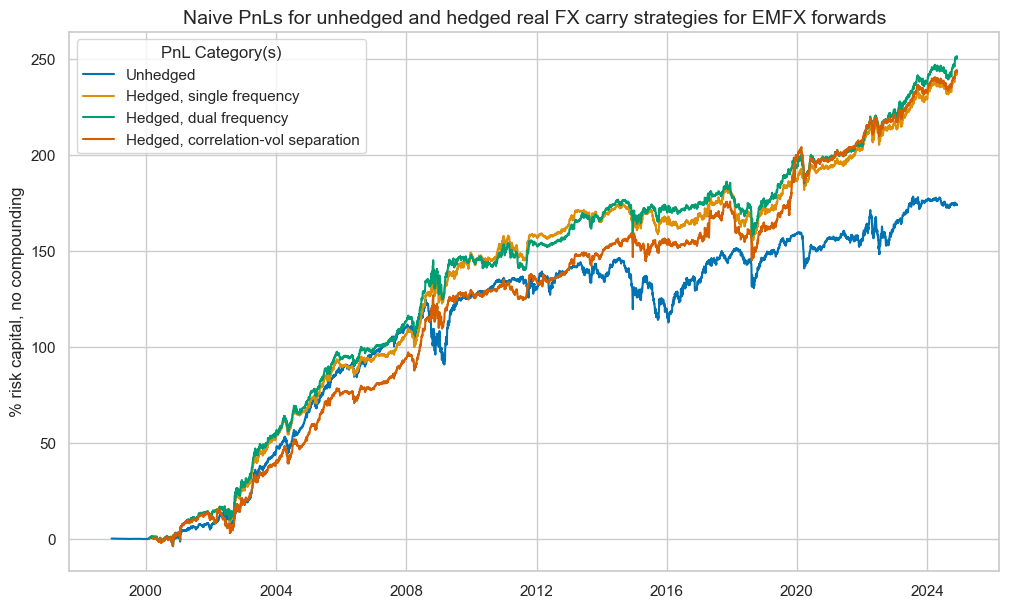

In [46]:
# Instantiate the MultiPnL class
ma_pnl = msn.MultiPnL()

ma_pnl.add_pnl(pnl=pnl_uh, pnl_xcats=["PNL_FXCRRW"])
ma_pnl.add_pnl(pnl=pnl_hsf, pnl_xcats=["PNL_FXCRRHvGDRB_OQRW"])
ma_pnl.add_pnl(pnl=pnl_hmf, pnl_xcats=["PNL_FXCRRHvGDRB_DFW"])
ma_pnl.add_pnl(pnl=pnl_hcv, pnl_xcats=["PNL_FXCRRHvGDRB_CVW"])

ma_pnl.plot_pnls(
    pnl_xcats=[
        "PNL_FXCRRW",
        "PNL_FXCRRHvGDRB_OQRW",
        "PNL_FXCRRHvGDRB_DFW",
        "PNL_FXCRRHvGDRB_CVW",
    ],
    title="Naive PnLs for unhedged and hedged real FX carry strategies for EMFX forwards",
    xcat_labels=[
        "Unhedged",
        "Hedged, single frequency",
        "Hedged, dual frequency",
        "Hedged, correlation-vol separation",
    ],
)

In [48]:
tbr = ma_pnl.evaluate_pnls()
dict_pnames = {
    "PNL_FXCRRW/FXXR_NSA": "Unhedged",
    "PNL_FXCRRHvGDRB_OQRW/FXXRHvGDRB_OQR": "Hedged, single frequency",
    "PNL_FXCRRHvGDRB_DFW/FXXRHvGDRB_DF": "Hedged, dual frequency",
    "PNL_FXCRRHvGDRB_CVW/FXXRHvGDRB_CV": "Hedged, correlation-vol separation",
}
tbr = tbr.iloc[[i for i in range(len(tbr)) if i != 1], :]
tbr.rename(columns=dict_pnames, inplace=True)

tbr = tbr.style.format("{:.2f}").set_caption(
    f"Naive PnL statistics for unhedged and hedged real EMFX carry strategies").set_table_styles(
    [{"selector": "caption", "props": [("text-align", "center"), ("font-weight", "bold"), ("font-size", "17px")]}])

display(tbr)